In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
import torch as torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch import optim
import warnings

warnings.simplefilter("ignore")

#### loading dataset to variables

In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_sample_size = 1000
test_sample_size = 100
train_per_class_size = 100
test_per_class_size = 10
num_class = 10

print(type(train_dataset[0]))

#print(type(train_dataset))
#print(train_dataset[0])
#print(type(test_dataset))
#print(type(test_dataset[0]))
#print(test_dataset[0][0][0].shape)
#print(test_dataset[0])
"""
plt.imshow(train_dataset[0][0][0], cmap="gray")
image = np.expand_dims(train_dataset[0][0][0], axis=2)
print(image.shape)
print(train_dataset[0][1])
plt.show()

plt.imshow(test_dataset[0][0][0], cmap="gray")
image1 = np.expand_dims(test_dataset[0][0][0], axis=2)
print(image1.shape)
print(test_dataset[0][1])
plt.show()
"""

#print(image)
Y_traindataset = list()

for i in range(len(train_dataset)):
  Y_traindataset.append(train_dataset[i][1])

Y_testdataset = list()

for i in range(len(test_dataset)):
  Y_testdataset.append(test_dataset[i][1])

XY_train = list()
XY_test = list()

for i in range(num_class):
    indices_train = np.where(np.array(Y_traindataset) == i)[0]
    for j in range(train_per_class_size):
        XY_train.append(train_dataset[indices_train[j]])
    indices_test = np.where(np.array(Y_testdataset) == i)[0]
    for j in range(test_per_class_size):
        XY_test.append(test_dataset[indices_test[j]])

#index, (images, labels) = enumerate(XY_train)
#print(images.shape)
#print(labels.shape)
#XY_train = TensorDataset(XY_train)
#XY_test = TensorDataset(XY_test)

#print(len(XY_train))
#print(XY_train[0][0].shape)

<class 'tuple'>


## Homework 4
#### Forward propogation

In [3]:
def hw2q3Replication_padding(channel, width, height, padding_width, padding_height, img):
    input = np.zeros((width + padding_width, height + padding_height, channel), float)
    for i in range(width):
        for j in range(height):
            for c in range(channel):
                input[i + int((padding_width)/2)][j + int((padding_height)/2)][c] = img[i][j][c]
    for i in range(0, int((padding_width)/2)):
        for j in range(int((padding_height)/2), height + int((padding_height)/2)):
            for c in range(channel):
                input[i][j][c] = input[padding_width - 1 - i][j][c]
                input[width + padding_width - 1 - i][j] = input[width + i][j] 
    for i in range(0, width + padding_width):
        for j in range(0, int((padding_height)/2)):
            for c in range(channel):
                input[i][j][c] = input[i][padding_height - 1 - j][c]
                input[i][height + padding_height - 1 - j] = input[i][height + j]
    return input

def hw3q1Striding(width, height, kernel_width, kernel_height, padding_width, padding_height, stride_width, stride_height, conv_output):
    output = np.zeros((int((width - kernel_width + padding_width + stride_width)/stride_width), int((height - kernel_height + padding_height + stride_height)/stride_height)), float)
    k=0
    i=0
    while(i >= 0 and i < (width - kernel_width + padding_width + 1) and k >= 0 and k < (int((width - kernel_width + padding_width + stride_width)/stride_width))):
        l = 0
        j = 0
        while(j >= 0 and j < (height - kernel_height + padding_height + 1) and l >= 0 and l < (int((height - kernel_height + padding_height + stride_height)/stride_height)) ):
            output[k][l] = conv_output[i][j]
            j = j + stride_height
            l = l + 1
        i = i + stride_width
        k = k + 1
    return output

def sigmoid(z):
    sig = (1.0/(1+np.exp(-z)))
    return sig

def tanh(z):
    return np.tanh(z)

def ReLU(z):
    return max(0, z)

def PReLU(z, alpha):
    return max(0, z) + alpha * min(0, z)

In [4]:
def hw3q1Convolution(img, kernel, stride, padding, nl_func, alpha=0):
    width = img.shape[0]
    height = img.shape[1]
    channel = img.shape[2]
    kernel_width = kernel.shape[0]
    kernel_height = kernel.shape[1]
    padding_width = padding[0]
    padding_height = padding[1]
    stride_width = stride[0]
    stride_height = stride[1]
    input = hw2q3Replication_padding(channel, width, height, padding_width, padding_height, img)
    conv_output = np.zeros((width  + padding_width , height + padding_height), float)
    for i in range(int((kernel_width-1)/2), width + padding_width - int((kernel_width-1)/2) ):
        for j in range(int((kernel_height-1)/2), height + padding_height - int((kernel_height-1)/2)):
            for c in range(channel):
                for k in range(-int((kernel_width - 1)/2), int((kernel_width - 1)/2) + 1):
                    for l in range(-int((kernel_height - 1)/2), int((kernel_height - 1)/2) + 1):
                        #if (i - k) >= 0 and (i - k) < (width - kernel_width + padding_width + 1) and (j - l) >= 0 and (j - l) < (height - kernel_height + padding_height + 1):
                        conv_output[i][j] += input[i - k][j - l][c] * kernel[int((kernel_width - 1)/2) + k][int((kernel_height - 1)/2)+ l][c]
                        #print(conv_output[i][j], input[i - k][j - l][c], " * ", kernel[int((kernel_width - 1)/2) + k][int((kernel_height - 1)/2)+ l][c])
    #print(conv_output)
    conv_output = conv_output[int((kernel_width - 1)/2):int(width + padding_width - int((kernel_width - 1)/2)), int((kernel_height - 1)/2):int(height + padding_height - int((kernel_height - 1)/2))].astype(float)
    #print("conv_output : ", conv_output)
    output_temp = hw3q1Striding(width, height, kernel_width, kernel_height, padding_width, padding_height, stride_width, stride_height, conv_output)
    before_activation = output_temp
    #output_temp = (255*(output_temp - np.min(output_temp))/np.ptp(output_temp)).astype(float)
    for i in range(int((width - kernel_width + padding_width + stride_width)/stride_width)):
        for j in range(int((height - kernel_height + padding_height + stride_height)/stride_height)):
            if nl_func == 'sigmoid':
                output_temp[i][j] = sigmoid(output_temp[i][j])
            elif nl_func == 'tanh':
                output_temp[i][j] = tanh(output_temp[i][j])
            elif nl_func == 'ReLU':
                output_temp[i][j] = ReLU(output_temp[i][j])
            elif nl_func == 'PReLU':
                output_temp[i][j] = PReLU(output_temp[i][j], alpha)
    #print(output_temp)
    return before_activation, output_temp

In [5]:
#Pooling function

def hw3q2Maximum(activation_pool):
    max = activation_pool[0][0]
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            if activation_pool[i][j] > max:
                max = activation_pool[i][j]
    return max

def hw3q2Average(activation_pool):
    sum = 0
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            sum += activation_pool[i][j]
    count = activation_pool.shape[0] * activation_pool.shape[1]
    return (sum/count)

def hw3q2Norm(activation_pool):
    sum = 0
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            sum += (activation_pool[i][j]*activation_pool[i][j])
    return np.sqrt(sum)

In [6]:
def hw3q2Pooling(activation_map, pool_func, pool_size, pool_stride):
    width = activation_map.shape[0]
    height = activation_map.shape[1]
    pool_width = pool_size[0]
    pool_height = pool_size[1]
    pool_stride_width = pool_stride[0]
    pool_stride_height = pool_stride[1]
    #print(activation_map.shape)
    Y = np.zeros((width - pool_width + 1, height - pool_height + 1), float)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            #print(activation_map[i:i+pool_width, j:j+pool_height].flatten().shape)
            if pool_func == 'maximum':
                Y[i][j] = hw3q2Maximum(activation_map[i:i+pool_width, j:j+pool_height])
            elif pool_func == 'average':
                Y[i][j] = hw3q2Average(activation_map[i:i+pool_width, j:j+pool_height])
            elif pool_func == 'norm':
                Y[i][j] = hw3q2Norm(activation_map[i:i+pool_width, j:j+pool_height])
    output = np.zeros((int((width - pool_width + pool_stride_width)/pool_stride_width), int((height - pool_height + pool_stride_height)/pool_stride_height)), float)
    i = 0
    k = 0
    while( i >= 0 and i < (width - pool_width + 1) and k >= 0 and k < int((width - pool_width + pool_stride_width)/pool_stride_width)):
        j = 0
        l = 0
        while( j >= 0 and j < (height - pool_height + 1) and l >= 0 and l < int((height - pool_height + pool_stride_height)/pool_stride_height)):
            output[k][l] = Y[i][j]
            j = j + pool_stride_height
            l = l + 1
        i = i + pool_stride_width
        k = k + 1
    return output

In [7]:
#convolution layer 

#def hw3q3RandomKernels(num_kernels, kernel_size):
def hw3q3RandomKernels(num_kernels, kernel_size, input_size):
    kernels = list()
    for m in range(num_kernels):
        #kernels.append(np.random.randn(kernel_size[0], kernel_size[1], kernel_size[2]))
        #temp = np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))
        kernels.append(np.random.uniform(low=-(np.sqrt(1/(input_size[0]*input_size[1]))), high=(np.sqrt(1/(input_size[0]*input_size[1]))), size=(kernel_size[0], kernel_size[1], kernel_size[2])))
        #kernels.append(np.random.uniform(low=-(np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))), high=(np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))), size =(kernel_size[0], kernel_size[1], kernel_size[2])))
        #print(kernels[m])
    return np.array(kernels)

def hw3q3RandomKernelBias(num_kernels, bias_size):
    return np.zeros((bias_size[0], bias_size[1], num_kernels), float)

def hw3q3ConvolutionLayer(img, kernels, kernel_bias, stride, padding, nl_func, alpha=0):
    width = img.shape[0]
    height = img.shape[1]
    channel = img.shape[2]
    stride_width = stride[0]
    stride_height = stride[1]
    padding_width = padding[0]
    padding_height = padding[1]
    kernel_width = kernels.shape[1]
    kernel_height = kernels.shape[2]
    output = np.zeros((int((width - kernel_width + padding_width + stride_width)/stride_width), int((height - kernel_height + padding_height + stride_height)/stride_height), kernels.shape[0]), float)
    before_activation_list = np.zeros(output.shape, float)
    for m in range(kernels.shape[0]):
        #print("kernel : ", kernels[m])
        before_activation, output_temp = hw3q1Convolution(img, kernels[m], stride, padding, nl_func, alpha)
        #before_activation_list.append(before_activation)
        #print("output_temp : ", output_temp)
        #plt.imshow(output_temp)
        #plt.show()
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                output[i][j][m] = output_temp[i][j]
                before_activation_list[i][j][m] = before_activation[i][j]
    output = output + np.transpose(kernel_bias)
    return before_activation_list, output

In [8]:
#Pooling Layer Function

def hw3q4PoolingLayer(activation_map, pool_func, pool_layer_size, pool_layer_stride):
    width = activation_map.shape[0]
    height = activation_map.shape[1]
    M = activation_map.shape[2]
    pool_layer_width = pool_layer_size[0]
    pool_layer_height = pool_layer_size[1]
    pool_layer_stride_width = pool_layer_stride[0]
    pool_layer_stride_height = pool_layer_stride[1]
    Y = np.zeros((int((width - pool_layer_width + pool_layer_stride_width)/pool_layer_stride_width), int((height - pool_layer_height + pool_layer_stride_height)/pool_layer_stride_height), M), float)
    for m in range(M):
        y = hw3q2Pooling(activation_map[:,:,m], pool_func,pool_layer_size, pool_layer_stride)
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                Y[i][j][m] = y[i][j]
    return Y

In [9]:
#Flattening (unraveling) Function

def hw3q5Flattening(pooled_volume, flattening_matrix, flattening_matrix_flag):
    array1d = list()
    for i in range(pooled_volume.shape[0]):
        for j in range(pooled_volume.shape[1]):
            for m in range(pooled_volume.shape[2]):
                array1d.append(pooled_volume[i][j][m])
    array1d = np.array(array1d)
    if flattening_matrix_flag:
        output = np.matmul(flattening_matrix, array1d)
    else:
        output = array1d
    return np.expand_dims(output, axis = 1)

In [10]:
#Multilayer Perceptron (MLP) function (Fully Connected)

def RandomMatrices(flattened_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size):
    hidden_layer_matrices = list()
    hidden_layer_bias = list()
    #hidden_layer_matrices.append(np.random.randn(hidden_layer_sizes[0], flattened_vector_size))
    hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/flattened_vector_size)), high=(np.sqrt(1/flattened_vector_size)), size=(hidden_layer_sizes[0], flattened_vector_size)))
    #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[0])), high=(np.sqrt(1/hidden_layer_sizes[0])), size=(hidden_layer_sizes[0], flattened_vector_size)))
    hidden_layer_bias.append(np.zeros((hidden_layer_sizes[0], 1), float))
    for t in range(num_hidden_layer):
        if t == (num_hidden_layer - 1):
            #hidden_layer_matrices.append(np.random.randn(output_layer_size, hidden_layer_sizes[t]))
            hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t])), high=(np.sqrt(1/hidden_layer_sizes[t])), size=(output_layer_size, hidden_layer_sizes[t])))
            #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/output_layer_size)), high=(np.sqrt(1/output_layer_size)), size=(output_layer_size, hidden_layer_sizes[t])))
            hidden_layer_bias.append(np.zeros((output_layer_size, 1), float))
        else:
            #hidden_layer_matrices.append(np.random.randn(hidden_layer_sizes[t+1], hidden_layer_sizes[t]))
            hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t])), high=(np.sqrt(1/hidden_layer_sizes[t])), size=(hidden_layer_sizes[t+1], hidden_layer_sizes[t])))
            #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t+1])), high=(np.sqrt(1/hidden_layer_sizes[t+1])), size=(hidden_layer_sizes[t+1], hidden_layer_sizes[t])))
            hidden_layer_bias.append(np.zeros((hidden_layer_sizes[t+1], 1), float))
        #print("hidden_layer_matrices :" , hidden_layer_matrices[t])
    return hidden_layer_matrices, hidden_layer_bias

def hw3q6MLP(input_vector, hidden_layer_matrices, hidden_layer_bias, nl_func, softmax_flag, alpha = 0):
    output_before_activation = list()
    output_after_activation = list()
    for i in range(len(hidden_layer_matrices)):
        if i == 0:
            #print("hidden_layer_matrices : ", hidden_layer_matrices[i].shape)
            #print("input vector : ", input_vector.shape)
            output = np.matmul(hidden_layer_matrices[i], input_vector)
        else:
            output = np.matmul(hidden_layer_matrices[i], output)
        #print("output:", output.shape)
        #print("output: ", output)
        output = output + hidden_layer_bias[i]
        #print(output.shape)
        #print(hidden_layer_bias[i].shape)
        #print("output:", output.shape)
        #print("output: ", output)
        output_before_activation.append(output)
        if i != (len(hidden_layer_matrices) - 1):
            for j in range(output.shape[0]):
                for k in range(output.shape[1]):
                    if nl_func == 'sigmoid':
                        output[j][k] = sigmoid(output[j][k])
                    elif nl_func == 'tanh':
                        output[j][k] = tanh(output[j][k])
                    elif nl_func == 'ReLU':
                        output[j][k] = ReLU(output[j][k])
                    elif nl_func == 'PReLU':
                        output[j][k] = leakyrelu(output[j][k], alpha)
            output_after_activation.append(output)
        elif i == (len(hidden_layer_matrices) - 1) and not softmax_flag:
            for j in range(output.shape[0]):
                for k in range(output.shape[1]):
                    if nl_func == 'sigmoid':
                        output[j][k] = sigmoid(output[j][k])
                    elif nl_func == 'tanh':
                        output[j][k] = tanh(output[j][k])
                    elif nl_func == 'ReLU':
                        output[j][k] = ReLU(output[j][k])
                    elif nl_func == 'PReLU':
                        output[j][k] = leakyrelu(output[j][k], alpha)
            output_after_activation.append(output)
        """
        for j in range(output.shape[0]):
            for k in range(output.shape[1]):
                if nl_func == 'sigmoid':
                    output[j][k] = sigmoid(output[j][k])
                elif nl_func == 'tanh':
                    output[j][k] = tanh(output[j][k])
                elif nl_func == 'ReLU':
                    output[j][k] = ReLU(output[j][k])
                elif nl_func == 'PReLU':
                    output[j][k] = leakyrelu(output[j][k], alpha)
        """
        #print("output: ", output)
    #print(output_before_activation[0].shape)
    return output_before_activation, output_after_activation, output

def hw3q6SoftmaxLayer(input):
    input = np.transpose(input)
    return np.transpose(np.exp(input-np.max(input,axis=1).reshape(-1,1))/np.expand_dims(np.sum(np.exp(input-np.max(input,axis=1).reshape(-1,1)),axis=1), axis=-1))
    """
    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            sum = sum + np.exp(input[i][j])
    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            input[i][j] = (np.exp(input[i][j])/sum)
    return np.transpose(input)
    """

In [11]:
def hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array):
    kernels_array = list()
    kernel_bias = list()
    final_pooled_output_size = list()
    for i in range(num_kernels_array.shape[0]):
        if i == 0:
            #kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], image.shape[2]))
            kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], image.shape[2]), [image.shape[0], image.shape[1]])
            temp_width = int((image.shape[0] - kernels_size_array[i][0] + layer_padding[i][0] + stride_array[i][0])/stride_array[i][0])
            temp_height = int((image.shape[1] - kernels_size_array[i][1] + layer_padding[i][1] + stride_array[i][1])/stride_array[i][1])
        else:
            #kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], num_kernels_array[i-1]))
            kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], num_kernels_array[i-1]), [layer_pooled_output_width, layer_pooled_output_height])
            temp_width = int((layer_pooled_output_width - kernels_size_array[i][0] + layer_padding[i][0] + stride_array[i][0])/stride_array[i][0])
            temp_height = int((layer_pooled_output_height - kernels_size_array[i][1] + layer_padding[i][1] + stride_array[i][1])/stride_array[i][1])
        kernel_bias_temp = np.zeros((num_kernels_array[i], 1, 1), float)
        kernels_array.append(kernels)
        kernel_bias.append(kernel_bias_temp)
        layer_pooled_output_width = int((temp_width - pool_layer_size_array[i][0] + pool_stride_array[i][0])/pool_stride_array[i][0])
        layer_pooled_output_height = int((temp_width - pool_layer_size_array[i][1] + pool_stride_array[i][1])/pool_stride_array[i][1])
    final_pooled_output_size.append(layer_pooled_output_width)
    final_pooled_output_size.append(layer_pooled_output_height)
    final_pooled_output_size.append(num_kernels_array[-1])
    return kernels_array, kernel_bias, final_pooled_output_size
        
def hw3q7FeedForwardPath(img, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag):
    output_before_kernel_act = list()
    output_after_kernel_act = list()
    pooled_output_list = list()
    pooled_output = img
    #print("img: ", img)
    for i in range(num_kernels_array.shape[0]):
        before_activation_list, output = hw3q3ConvolutionLayer(pooled_output, kernels_array[i], kernel_bias[i], stride_array[i], layer_padding[i], nl_func)
        #print("before_activation_list: ", before_activation_list)
        #print("output: ", output)
        output_before_kernel_act.append(before_activation_list)
        output_after_kernel_act.append(output)
        #print(conv_output.shape)
        pooled_output = hw3q4PoolingLayer(output, pool_func, pool_layer_size_array[i], pool_stride_array[i])
        #print("pooled_output: ", pooled_output)
        pooled_output_list.append(pooled_output)
        #print(pooled_output.shape)
    flattened_output = hw3q5Flattening(pooled_output, flattening_matrix, flattening_matrix_flag)
    output_before_activation, output_after_activation, MLP_output = hw3q6MLP(flattened_output, hidden_layer_matrices, hidden_layer_bias, nl_func, softmax_flag)
    #print("MLP ouptut : ", MLP_output)
    if softmax_flag:
        softmax_output = hw3q6SoftmaxLayer(MLP_output)
        output_after_activation.append(softmax_output)
    return output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, np.transpose(softmax_output)[0]

In [12]:
def hw1q3aEntropy(pmf):
    pmf = pmf[pmf > 0]
    h = -np.sum(pmf * np.log2(pmf))
    if(h == -0.0):
        return np.abs(h)
    else:
        return h

def hw1q7aRelativeEntropy(pmf1, pmf2):
    h = 0
    for i in range(pmf1.shape[0]):
        if pmf1[i] == 0.0 or pmf2[i] == 0.0:
            continue
        temp = pmf1[i] * np.log2(pmf1[i]/pmf2[i])
        #print(temp)
        h += temp
    return h

def hw2q1aCrossEntropy(pmf1, pmf2):
    div = hw1q7aRelativeEntropy(pmf1, pmf2)
    ent = hw1q3aEntropy(pmf1)
    cross_ent = ent + div
    return cross_ent

#### single image Example taken for forward propogation and calculating cross entropy loss 

Ouput vector size :  (10,)
[0.10152674 0.0968701  0.09728597 0.09879712 0.10156165 0.10304792
 0.10157419 0.09977231 0.09805518 0.10150883]


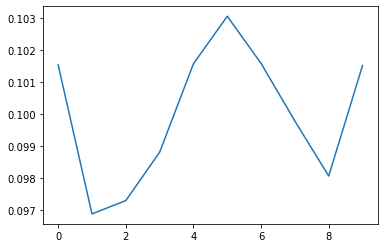

3.278612694393397


In [17]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5,5], [5,5]])
layer_padding = np.array([[0, 0], [0,0]])
stride_array = np.array([[1,1], [1,1]])
pool_layer_size_array = np.array([[2,2], [2,2]])
pool_stride_array = np.array([[2,2], [2,2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = True

if flattening_matrix_flag:
    flattening_vector_size = 40
else:
    width = image.shape[0]
    height = image.shape[1]
    for i in range(num_kernels_array.shape[0]):
        width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
        height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
    flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]

kernels_array, kernel_bias, final_pooled_output_size = hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array)

hidden_layer_matrices, hidden_layer_bias = RandomMatrices(flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size)

#print("kernels_array :", kernels_array)
#print("kernel_bias :", kernel_bias)
#print("hidden_layer_matrices :", hidden_layer_matrices)
#print("hidden_layer_bias :", hidden_layer_bias)

flattening_matrix = np.random.randn(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2])
#flattening_matrix = np.random.uniform(low=-(np.sqrt(1/(final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))), high=(np.sqrt(1/(final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))), size=(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))

#print("before image : ", image)
#image1 = (image - 0.5)/0.5
#print("image : ", image1)

output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(image, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)

"""
print("value of C2 is equal to the number of kernels in the previous convolution layer - 16")
print("original input image size : ", image.shape)
print("original image")
plt.imshow(image)
plt.show()
"""

print("Ouput vector size : ", output_vector.shape)
print(output_vector)
plt.plot(output_vector)
plt.show()

y_hat = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
print(hw2q1aCrossEntropy(y_hat, output_vector))


#### Backward propogation (q3)

In [13]:
def hw4q3ZeroPadding(channel, width, height, padding_width, padding_height, img):
    input = np.zeros((width + padding_width, height + padding_height, channel), float)
    for i in range(width):
        for j in range(height):
            for c in range(channel):
                input[i + int((padding_width)/2)][j + int((padding_height)/2)][c] = img[i][j][c]
    return input

def hw4q3LinearDerivatives(dZ, A, W, b):
    #print(dZ.shape)
    #print(A.shape)
    #print(W.shape)
    #print(b.shape)
    dW = np.zeros((W.shape[0], W.shape[1]), float)
    for i in range(dW.shape[0]):
        for j in range(dW.shape[1]):
            #print("dZ : ", dZ[i], A[j])
            dW[i][j] = dZ[i]*A[j]
            #print("W :", W[i][j])
    #print(dW.shape)
    db = np.sum(dZ, axis = 1, keepdims = True)
    #print("db: ", db.shape)
    dA_prev = np.zeros(A.shape, float)
    for i in range(dA_prev.shape[0]):
        for j in range(dA_prev.shape[1]):
            dA_prev[i][j] = np.sum(np.multiply(dZ[:, 0], W[:, i]))
    return dA_prev, dW, db

def softmaxDerivative(dA, Z):
    #print("Z : ", Z)
    #print(Z.shape)
    #print("dA : ", dA.shape)
    exp_Z = np.exp(Z)
    dZ = np.zeros(Z.shape, float)
    #print("exp_z: ", exp_Z)
    A = exp_Z / np.sum(exp_Z)
    for i in range(dZ.shape[0]):
        for j in range(dZ.shape[1]):
            dZ[i][j] = dA[i][j] * A[i][j] * ( 1 - A[i][j])
    """
    dA_A = np.sum(dA * A, axis = 0)
    temp = dA - dA_A
    dZ = A * temp
    """
    return dZ

def sigmoidDerivative(dA, Z):
    temp = 1 / (1 + np.exp(-Z))
    dZ = dA * temp * (1 - temp)
    return dZ

def ReLUDerivative(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def hw4q3ActivationDerivatives(dA, Z, A, W, b, nl_func):
    #print("dA" , dA.shape)
    #print("Z" , Z.shape)
    #print("A" , A.shape)
    #print("W" , W.shape)
    #print("b" , b.shape)
    if nl_func == "softmax":
        dZ = softmaxDerivative(dA, Z)
    elif nl_func == "sigmoid":
        dZ = sigmoidDerivative(dA, Z)
    elif nl_func == "ReLU":
        dZ = ReLUDerivative(dA, Z)
        
    #print("dZ : ", dZ)
    dA_prev, dW, db = hw4q3LinearDerivatives(dZ, A, W, b)
    #print("dW :", dW)
    #print("db :", db)
    
    return dA_prev, dZ, dW, db

def hw4q3KernelActivationDerivative(dP, Z, A, W, b, kernel_size, stride_size, nl_func, layer_padding):
    dZ = np.zeros(dP.shape, float)
    for k in range(dP.shape[2]):
        if nl_func == "softmax":
            dZ_temp = softmaxDerivative(dP[:, :, k], Z[:, :, k])
        elif nl_func == "sigmoid":
            dZ_temp = sigmoidDerivative(dP[:, :, k], Z[:, :, k])
        elif nl_func == "ReLU":
            dZ_temp = ReLUDerivative(dP[:, :, k], Z[:, :, k])
        for i in range(dP.shape[0]):
            for j in range(dP.shape[1]):
                dZ[i][j][k] = dZ_temp[i][j]
    dA_prev = np.zeros((A.shape[0] + layer_padding[0], A.shape[1] + layer_padding[1], A.shape[2]), float)
    #print(dA_prev.shape)
    dW = np.zeros(W.shape, float)
    #print(dW.shape)
    db = np.zeros(b.shape, float)
    #print(db.shape)

    A_repl = hw2q3Replication_padding(A.shape[2], A.shape[0], A.shape[1], layer_padding[0], layer_padding[1], A)
    for k in range(W.shape[0]):
        for c in range(W.shape[3]):
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    #print(A_repl[(A_repl.shape[0] - dZ.shape[0] - i):(A_repl.shape[0] - i):stride_size[0], (A_repl.shape[1] - dZ.shape[1] - j):(A_repl.shape[1] - j):stride_size[1], c])
                    #print(dZ[:, :, k])
                    dW[k, i, j, c] += np.sum(np.multiply(A_repl[(A_repl.shape[0] - dZ.shape[0] - i):(A_repl.shape[0] - i):stride_size[0], (A_repl.shape[1] - dZ.shape[1] - j):(A_repl.shape[1] - j):stride_size[1], c], dZ[:, :, k]))

    dZ_padd = hw4q3ZeroPadding(dZ.shape[2], dZ.shape[0], dZ.shape[1], 2 * (W.shape[1] - 1), 2 * (W.shape[2] - 1), dZ)
    for k in range(dA_prev.shape[2]):
        for i in range(dA_prev.shape[0]):
            for j in range(dA_prev.shape[1]):
                for m in range(dZ.shape[2]):
                    dA_prev[i, j, k] += np.sum(np.multiply(W[m, :, :, k], dZ_padd[i:i+W.shape[1], j:j+W.shape[2], m]))
    dA_prev = dA_prev[int(layer_padding[0]/2):dA_prev.shape[0] - int(layer_padding[0]/2), int(layer_padding[1]/2):dA_prev.shape[1] - int(layer_padding[1]/2), :]
    
    for m in range(dZ.shape[2]):
        db[m, 0, 0] = np.sum(dZ[:, :, m])

    return dA_prev, dZ, dW, db

def hw4q3PoolDerivative(dP, output, pool_size, pool_stride_size):
    dX = np.zeros((output.shape[0], output.shape[1], output.shape[2]), float)
    for k in range(output.shape[2]):
        for i in range(0, output.shape[0] - pool_size[0] + 1, pool_stride_size[0]):
            for j in range(0, output.shape[0] - pool_size[1] + 1, pool_stride_size[1]):
                index_1d = np.argmax(output[i:i+pool_size[0], j:j+pool_size[1], k])
                (idx, idy) = np.unravel_index(index_1d, (pool_size[0], pool_size[1]))
                dX[i+idx, j+idy, k] += dP[int(i/pool_stride_size[0]), int(j/pool_stride_size[1]), k]
    return dX

def hw4q3FlatteningDerivative(dO, pooled_output, flattening_matrix, flattening_matrix_flag):
    array1d = list()
    for i in range(pooled_output.shape[0]):
        for j in range(pooled_output.shape[1]):
            for m in range(pooled_output.shape[2]):
                array1d.append(pooled_output[i][j][m])
    array1d = np.expand_dims(np.array(array1d), axis = 1)
    if flattening_matrix_flag:
        dF = np.matmul(dO, array1d.T)
    #print(dW.shape)
    #db = np.sum(dZ, axis = 1, keepdims = True)
    #print("db: ", db.shape)
        dP_temp = np.matmul(flattening_matrix.T, dO)
    else: 
        dP_temp = dO
    dP = np.zeros((pooled_output.shape[0], pooled_output.shape[1], pooled_output.shape[2]), float)
    n = 0
    for i in range(pooled_output.shape[0]):
        for j in range(pooled_output.shape[1]):
            for m in range(pooled_output.shape[2]):
                dP[i][j][m] = dP_temp[n][0]
                n += 1
    if flattening_matrix_flag:
        return dP, dF
    else:
        return dP

def hw4q3LayerDerivatives(input_img, output_vector, y_hat, output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias,  output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding):
    L = len(hidden_layer_matrices)
    #print(output_vector.shape)
    #print(y_hat.shape)
    dAF = np.expand_dims(- (np.divide(y_hat, output_vector)), axis = 1)
    #print(dAF.shape)
    dA_array = [None] * L
    dZ_array = [None] * L
    dW_array = [None] * L
    db_array = [None] * L
    for i in reversed(range(L)):
        if i == L - 1:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dAF, output_before_activation[i], output_after_activation[i - 1], hidden_layer_matrices[i], hidden_layer_bias[i], "softmax")
        elif i == 0:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dA_array[i + 1], output_before_activation[i], flattened_output, hidden_layer_matrices[i], hidden_layer_bias[i], nl_func)
        else:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dA_array[i + 1], output_before_activation[i], output_after_activation[i - 1], hidden_layer_matrices[i], hidden_layer_bias[i], nl_func)
        #print("dW_temp : ", dW_temp)
        dA_array[i] = dA_temp
        dZ_array[i] = dZ_temp
        dW_array[i] = dW_temp
        db_array[i] = db_temp
        """
        if i == 0:
            print("dA_temp:", dA_temp.shape)
            print("dZ_temp:", dZ_temp.shape)
            print("dW_temp:", dW_temp.shape)
            print("db_temp:", dW_temp.shape)
        
            print("dA_array: ", dA_array)
            print("dZ_array: ", dZ_array)
            print("dW_array: ", dW_array)
            print("db_array: ", db_array)
        print("Layer {} completed".format(i))
        """
    if flattening_matrix_flag:
        dP, dF = hw4q3FlatteningDerivative(dA_array[0], pooled_output_list[len(pooled_output_list) - 1], flattening_matrix, flattening_matrix_flag)
    else:
        dP = hw4q3FlatteningDerivative(dA_array[0], pooled_output_list[len(pooled_output_list) - 1], flattening_matrix, flattening_matrix_flag)
    ker_L = len(pooled_output_list)
    dP_array = np.array([None] * ker_L)
    dA_kernellayer_array = [None] * ker_L
    dZ_kernellayer_array = [None] * ker_L
    dW_kernellayer_array = [None] * ker_L
    db_kernellayer_array = [None] * ker_L
    for j in reversed(range(ker_L)):
        if j == ker_L - 1:
            dP_temp = hw4q3PoolDerivative(dP, output_after_kernel_act[j], pool_layer_size_array[j], pool_stride_array[j])
        else:
            dP_temp = hw4q3PoolDerivative(dA_kernellayer_array[j + 1], output_after_kernel_act[j], pool_layer_size_array[j], pool_stride_array[j])
        if j == 0:
            dA_kernellayer_prev_temp, dZ_kernellayer_temp, dW_kernellayer_temp, db_kernellayer_temp = hw4q3KernelActivationDerivative(dP_temp, output_before_kernel_act[j], input_img, kernels_array[j], kernel_bias[j], kernels_size_array[j], stride_array[j], nl_func, layer_padding[j])
        else:
            dA_kernellayer_prev_temp, dZ_kernellayer_temp, dW_kernellayer_temp, db_kernellayer_temp = hw4q3KernelActivationDerivative(dP_temp, output_before_kernel_act[j], pooled_output_list[j - 1], kernels_array[j], kernel_bias[j], kernels_size_array[j], stride_array[j], nl_func, layer_padding[j])
        """
        if j == 0:
            print("dA_kernellayer_prev_temp : ", dA_kernellayer_prev_temp.shape)
            print("dZ_kernellayer_temp: ", dZ_kernellayer_temp.shape)
            print("dW_kernellayer_temp: ", dW_kernellayer_temp.shape)
            print("db_kernellayer_temp: ", db_kernellayer_temp.shape)
        """
        dA_kernellayer_array[j] = dA_kernellayer_prev_temp
        dZ_kernellayer_array[j] = dZ_kernellayer_temp
        dW_kernellayer_array[j] = dW_kernellayer_temp
        db_kernellayer_array[j] = db_kernellayer_temp
    
    if flattening_matrix_flag:
        return dA_array, dZ_array, dW_array, db_array, dF, dA_kernellayer_array, dZ_kernellayer_array, dW_kernellayer_array, db_kernellayer_array
    else:
        return dA_array, dZ_array, dW_array, db_array, dA_kernellayer_array, dZ_kernellayer_array, dW_kernellayer_array, db_kernellayer_array

def hw4q3SGD(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, flattening_matrix_flag):
    for i in range(len(hidden_layer_matrices)):
        #print("hidden_layer : ", hidden_layer_matrices[i])
        #print("dW_Array : ", dW_array[i])
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], dW_array[i] * learning_rate)
        #print("hidden_layer _ update :", hidden_layer_matrices[i])
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], learning_rate * db_array[i])
    if flattening_matrix_flag:
        flattening_matrix = np.subtract(flattening_matrix, learning_rate * dF)
    for i in range(len(kernels_array)):
        kernels_array[i] = np.subtract(kernels_array[i], learning_rate * dW_kernellayer_array[i])
        kernel_bias[i] = np.subtract(kernel_bias[i], learning_rate * db_kernellayer_array[i])
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias

def hw4q3Momentum(hidden_layer_matrices, hidden_layer_bias, dW_array, db_array, flattening_matrix, dF, kernels_array, kernel_bias, dW_kernellayer_array, db_kernellayer_array, change_momentum_W, change_momentum_b, change_momentum_F, change_momentum_W_kernel, change_momentum_b_kernel, flattening_matrix_flag, learning_rate, alpha):
    for i in range(len(hidden_layer_matrices)):
        change_momentum_W[i] = np.add(learning_rate * dW_array[i], alpha * change_momentum_W[i])
        change_momentum_b[i] = np.add(learning_rate * db_array[i], alpha * change_momentum_b[i])
        #print("Changed momentum : ", change_momentum_W[i].shape)
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], change_momentum_W[i])
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], change_momentum_b[i])
    if flattening_matrix_flag:
        flattening_matrix = np.subtract(flattening_matrix, np.add(learning_rate * dF, alpha * change_momentum_F))
        change_momentum_F = np.add(learning_rate * dF, alpha * change_momentum_F)
    for i in range(len(kernels_array)):
        kernels_array[i] = np.subtract(kernels_array[i], np.add(learning_rate * dW_kernellayer_array[i], alpha * change_momentum_W_kernel[i]))
        kernel_bias[i] = np.subtract(kernel_bias[i], np.add(learning_rate * db_kernellayer_array[i], alpha * change_momentum_b_kernel[i]))
        change_momentum_W_kernel[i] = np.add(learning_rate * dW_kernellayer_array[i], alpha * change_momentum_W_kernel[i])
        change_momentum_b_kernel[i] = np.add(learning_rate * db_kernellayer_array[i], alpha * change_momentum_b_kernel[i])
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, change_momentum_W, change_momentum_b, change_momentum_W_kernel, change_momentum_b_kernel, change_momentum_F

def hw4q3RMSProp(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_W_kernel, sq_b_kernel, sq_F, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, rho):
    #print("hidden_layer_matrices : ", hidden_layer_matrices)
    #print("hidden_layer_bias : ", hidden_layer_bias)
    #print("flattening_matrix : ", flattening_matrix)
    #print("kernels_array : ", kernels_array)
    #print("kernel_bias : " , kernel_bias)
    for i in range(len(hidden_layer_matrices)):
        #print("sq_W in : ", sq_W[i].shape)
        #print("sq_b in : ", sq_b[i].shape)
        #print("dW_array in : ", dW_array[i].shape)
        #print("db_array in : ", db_array[i].shape)
        sq_W[i] = np.add(rho * sq_W[i], (1 - rho) * dW_array[i])
        sq_b[i] = np.add(rho * sq_b[i], (1 - rho) * db_array[i])
        #print("sq_W out : ", sq_W[i].shape)
        #print("sq_b out : ", sq_b[i].shape)
        #print("dW_array out : ", dW_array[i].shape)
        #print("db_array out : ", db_array[i].shape)
        #print("np.sqrt(db_array[i]) out : ", np.sqrt(db_array[i]).shape)
        #print("np.sqrt(sq_b[i] out : ", np.sqrt(sq_b[i]).shape)
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], np.divide(learning_rate * np.sqrt(dW_array[i]), np.sqrt(sq_W[i]) + 1e-08))
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], np.divide(learning_rate * np.sqrt(db_array[i]), np.sqrt(sq_b[i]) + 1e-08))
    if flattening_matrix_flag:
        sq_F = np.add(rho * sq_F, (1 - rho) * dF)
        flattening_matrix = np.subtract(flattening_matrix, np.divide(learning_rate * np.sqrt(dF), np.sqrt(sq_F)))
    for i in range(len(kernels_array)):
        sq_W_kernel[i] = np.add(rho * sq_W_kernel[i], (1 - rho) * dW_kernellayer_array[i])
        sq_b_kernel[i] = np.add(rho * sq_b_kernel[i], (1 - rho) * db_kernellayer_array[i])
        kernels_array[i] = np.subtract(kernels_array[i], np.divide(learning_rate * np.sqrt(dW_kernellayer_array[i]), np.sqrt(sq_W_kernel[i]) + 1e-08))
        kernel_bias[i] = np.subtract(kernel_bias[i], np.divide(learning_rate * np.sqrt(db_kernellayer_array[i]), np.sqrt(sq_b_kernel[i]) + 1e-08))
    #print("hidden_layer_matrices : ", hidden_layer_matrices)
    #print("hidden_layer_bias : ", hidden_layer_bias)
    #print("flattening_matrix : ", flattening_matrix)
    #print("kernels_array : ", kernels_array)
    #print("kernel_bias : " , kernel_bias)
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_F, sq_W_kernel, sq_b_kernel

def evaluate(XY_test, 
            kernels_array, 
            kernel_bias,
            hidden_layer_matrices,
            hidden_layer_bias,
            flattening_matrix,
            num_kernels_array, 
            kernels_size_array, 
            layer_padding, 
            stride_array,
            pool_layer_size_array,
            pool_stride_array,
            flattening_vector_size,
            num_hidden_layer,
            hidden_layer_sizes,
            output_layer_size,
            softmax_flag,
            nl_func,
            pool_func,
            flattening_matrix_flag,
            y_mapping):
    loss = 0
    accuracy = 0.0
    flattened_outputs = list()
    original_Y = list()
    for index, sample in enumerate(XY_test):
        X = sample[0][0]
        X = (X - 0.5)/0.5
        X = np.expand_dims(X, axis = 2)
        Y = sample[1]
        #print(X.shape)
        output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(X, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)
        flattened_outputs.append(flattened_output)
        original_Y.append(Y)
        if np.argmax(output_vector) == Y:
            accuracy += 1.0
        loss += hw2q1aCrossEntropy(y_mapping[Y], output_vector)
        #print("output : ", output_vector)
        #print("original output : ", Y)
        
        if (index + 1)%len(XY_test) == 0:
            plt.subplot(3, 3, 1)
            plt.title("original")
            plt.imshow(X, cmap="gray")
            for j in range(len(output_after_activation)):
                plt.subplot(3, 3, j + 2)
                plt.title("layer {} activation".format(j + 1))
                #print(output_after_activation[j].shape)
                plt.imshow(output_after_kernel_act[j][:, :, 0], cmap="gray")
            plt.show()
    return loss/len(XY_test), accuracy/len(XY_test), np.array(flattened_outputs), np.array(original_Y)

#y_mapping = np.identity(output_layer_size)
#evaluate(XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, y_mapping)
        

#### training function ( contains every epoch training with train data and evaluation of test data for each epoch)
#### q4, q5

In [14]:

def train(XY_train,
          XY_test,
           kernels_array, 
          kernel_bias, 
          hidden_layer_matrices, 
          hidden_layer_bias,
            flattening_matrix,
            num_kernels_array, 
          kernels_size_array, 
          layer_padding, 
          stride_array,
          pool_layer_size_array,
          pool_stride_array,
          flattening_vector_size,
          num_hidden_layer,
          hidden_layer_sizes,
          output_layer_size,
          softmax_flag,
          nl_func,
          pool_func,
          update_func,
          flattening_matrix_flag,
          num_epochs = 30, 
          batch_size = 1,
          learning_rate = 0.01, 
          alpha = 0.9, 
          rho = 0.9
         ):
    
    y_mapping = np.identity(output_layer_size)
    
    #print(y_mapping)
    """
    print("hidden_layer_matrices: ", hidden_layer_matrices)
    print("hidden_layer_bias: ", hidden_layer_bias)
    print("Flattening_matrix: ", flattening_matrix)
    print("kernels_array: ", kernels_array)
    print("kernel_bias: ", kernel_bias)
    """
    if update_func == "momentum":
        change_momentum_W = list()
        change_momentum_b = list()
        for k in range(num_hidden_layer + 1):
            change_momentum_W.append(np.zeros(hidden_layer_matrices[k].shape, float))
            change_momentum_b.append(np.zeros(hidden_layer_bias[k].shape, float))
        change_momentum_W_kernel = list()
        change_momentum_b_kernel = list()
        for k in range(num_kernels_array.shape[0]):
            change_momentum_W_kernel.append(np.zeros(kernels_array[k].shape, float))
            change_momentum_b_kernel.append(np.zeros(kernel_bias[k].shape, float))
        change_momentum_F = np.zeros(flattening_matrix.shape, float)
    elif update_func == "RMSProp":
        sq_W = list()
        sq_b = list()
        for k in range(num_hidden_layer + 1):
            sq_W.append(np.zeros(hidden_layer_matrices[k].shape, float))
            sq_b.append(np.zeros(hidden_layer_bias[k].shape, float))
        sq_W_kernel = list()
        sq_b_kernel = list()
        for k in range(num_kernels_array.shape[0]):
            sq_W_kernel.append(np.zeros(kernels_array[k].shape, float))
            sq_b_kernel.append(np.zeros(kernel_bias[k].shape, float))
        sq_F = np.zeros(flattening_matrix.shape, float)
    loss_train = [0.0] * num_epochs
    loss_test = [0.0] * num_epochs
    avg_accuracy = [0.0] * num_epochs
    flattened_outputs_list = list()
    original_Y_list = list()
    
    for i in range(num_epochs):
        
        np.random.shuffle(XY_train)
        
        dW_array = [None] * (num_hidden_layer + 1)
        db_array = [None] * (num_hidden_layer + 1)
        for j in range(num_hidden_layer + 1):
            dW_array[j] = np.zeros(hidden_layer_matrices[j].shape, float)
            db_array[j] = np.zeros(hidden_layer_bias[j].shape, float)
        dF = np.zeros(flattening_matrix.shape, float)
        dW_kernellayer_array = [None] * num_kernels_array.shape[0]
        db_kernellayer_array = [None] * num_kernels_array.shape[0]
        for j in range(num_kernels_array.shape[0]):
            dW_kernellayer_array[j] = np.zeros(kernels_array[j].shape, float)
            db_kernellayer_array[j] = np.zeros(kernel_bias[j].shape, float)

        for index, sample in enumerate(XY_train):
            
            X = sample[0][0]
            X = (X - 0.5)/0.5
            X = np.expand_dims(X, axis = 2)
            Y = sample[1]
            
            output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(X, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)
            #print("y_hat: ", y_mapping[Y])
            #print("output_vector: ", output_vector)
            
            if flattening_matrix_flag:
                dA_array_temp, dZ_array_temp, dW_array_temp, db_array_temp, dF_temp, dA_kernellayer_array_temp, dZ_kernellayer_array_temp, dW_kernellayer_array_temp, db_kernellayer_array_temp = hw4q3LayerDerivatives(X, output_vector, y_mapping[Y], output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias, output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding)
            else:
                dA_array_temp, dZ_array_temp, dW_array_temp, db_array_temp, dA_kernellayer_array_temp, dZ_kernellayer_array_temp, dW_kernellayer_array_temp, db_kernellayer_array_temp = hw4q3LayerDerivatives(X, output_vector, y_mapping[Y], output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias, output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding)
            
            loss_train[i] += hw2q1aCrossEntropy(y_mapping[Y], output_vector)
            if update_func == "RMSProp":
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.add(dW_array[j], np.multiply(dW_array_temp[j], dW_array_temp[j]))
                    db_array[j] = np.add(db_array[j], np.multiply(db_array_temp[j], db_array_temp[j]))
                #print("dW_array_temp :",  dW_array_temp)
                #print("dW_array : ", dW_array)
                if flattening_matrix_flag:
                    dF = np.add(dF, np.multiply(dF_temp, dF_temp))
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.add(dW_kernellayer_array[j], np.multiply(dW_kernellayer_array_temp[j], dW_kernellayer_array_temp[j]))
                    db_kernellayer_array[j] = np.add(db_kernellayer_array[j], np.multiply(db_kernellayer_array_temp[j], db_kernellayer_array_temp[j]))
            else:
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.add(dW_array[j], dW_array_temp[j])
                    db_array[j] = np.add(db_array[j], db_array_temp[j])
                #print("dW_array_temp :",  dW_array_temp)
                #print("dW_array : ", dW_array)
                if flattening_matrix_flag:
                    dF = np.add(dF, dF_temp)
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.add(dW_kernellayer_array[j], dW_kernellayer_array_temp[j])
                    db_kernellayer_array[j] = np.add(db_kernellayer_array[j], db_kernellayer_array_temp[j])

            if (index + 1)%batch_size == 0:
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = dW_array[j]/batch_size
                    #print("dW_array[{}] : {}".format(j, dW_array[j].shape))
                    db_array[j] = db_array[j]/batch_size
                    #print("db_array[{}] : {}".format(j, db_array[j].shape))
                if flattening_matrix_flag:
                    dF = dF/batch_size
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = dW_kernellayer_array[j]/batch_size
                    db_kernellayer_array[j] = db_kernellayer_array[j]/batch_size
                #print("hidden_layer_bias in: ", hidden_layer_bias[0].shape)
                #print("hidden_layer_bias in : ", hidden_layer_bias[1].shape)
                #print("dW_array : ", dW_array)
                if update_func == "SGD":
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias = hw4q3SGD(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, flattening_matrix_flag)
                elif update_func == "momentum":
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, change_momentum_W, change_momentum_b, change_momentum_W_kernel, change_momentum_b_kernel, change_momentum_F = hw4q3Momentum(hidden_layer_matrices, hidden_layer_bias, dW_array, db_array, flattening_matrix, dF, kernels_array, kernel_bias, dW_kernellayer_array, db_kernellayer_array, change_momentum_W, change_momentum_b, change_momentum_F, change_momentum_W_kernel, change_momentum_b_kernel, flattening_matrix_flag, learning_rate, alpha)
                elif update_func == "RMSProp":
                    #print("entering here")
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_F, sq_W_kernel, sq_b_kernel = hw4q3RMSProp(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_W_kernel, sq_b_kernel, sq_F, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, rho)
                    
                #print("loss for last image for epoch {} and batch number {}: {}".format(i, (index + 1)/batch_size, loss/batch_size))
                #print("loss for last image for epoch {} and batch number {}".format(i, (index + 1)/batch_size))
                """
                print("hidden_layer_matrices: ", hidden_layer_matrices)
                print("dW_array: ", dW_array)
                print("hidden_layer_bias: ", hidden_layer_bias)
                print("db_array: ", db_array)
                print("Flattening_matrix: ", flattening_matrix)
                print("dF: ", dF)
                print("kernels_array: ", kernels_array)
                print("dW_kernellayer_array: ", dW_kernellayer_array)
                print("kernel_bias: ", kernel_bias)
                print("db_kernellayer_array: ", db_kernellayer_array)
                """
                #print("hidden_layer_bias out : ", hidden_layer_bias[0].shape)
                #print("hidden_layer_bias out: ", hidden_layer_bias[1].shape)
                
                dW_array = [None] * (num_hidden_layer + 1)
                db_array = [None] * (num_hidden_layer + 1)
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.zeros(hidden_layer_matrices[j].shape, float)
                    db_array[j] = np.zeros(hidden_layer_bias[j].shape, float)
                dF = np.zeros(flattening_matrix.shape, float)
                dW_kernellayer_array = [None] * num_kernels_array.shape[0]
                db_kernellayer_array = [None] * num_kernels_array.shape[0]
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.zeros(kernels_array[j].shape, float)
                    db_kernellayer_array[j] = np.zeros(kernel_bias[j].shape, float)
            #print(dW_array)
        loss_test[i], avg_accuracy[i], flattened_outputs, original_Y = evaluate(XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, y_mapping)
        if i == 0:
            flattened_outputs_list.append(flattened_outputs)
            original_Y_list.append(original_Y)
        elif i == (num_epochs - 1):
            flattened_outputs_list.append(flattened_outputs)
            original_Y_list.append(original_Y)
        print("Train loss for epoch {} : {}".format(i, loss_train[i]/len(XY_train)))
        print("Test loss for epoch {} : {}".format(i, loss_test[i]))
        print("Accuracy for epoch {} : {}%".format(i, avg_accuracy[i]*100))
    
    plt.plot(list(range(num_epochs)), loss_train, '-go')
    plt.title("train loss")
    plt.show()
    plt.plot(list(range(num_epochs)), loss_test, '-bo')
    plt.title("test loss")
    plt.show()
    parameters = dict()
    parameters["kernels_array"] = kernels_array
    parameters["kernel_bias"] = kernel_bias
    parameters["hidden_layer_matrices"] = hidden_layer_matrices
    parameters["hidden_layer_bias"] = hidden_layer_bias
    parameters["flattening_matrix"] = flattening_matrix
    return avg_accuracy, parameters, flattened_outputs_list, original_Y_list



In [17]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5, 5], [5, 5]])
layer_padding = np.array([[4, 4], [4, 4]])
stride_array = np.array([[1, 1], [1, 1]])
pool_layer_size_array = np.array([[2, 2], [2, 2]])
pool_stride_array = np.array([[2, 2], [2, 2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = False

num_epochs1 = 15
batch_size1 = 40.0
learning_rate = 0.001
alpha = 0.9
rho = 0.9

if flattening_matrix_flag:
    flattening_vector_size = 40
else:
    width = XY_train[0][0][0].shape[0]
    height = XY_train[0][0][0].shape[1]
    for i in range(num_kernels_array.shape[0]):
        width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
        height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
    flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]


kernels_array, kernel_bias, final_pooled_output_size = hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array)

hidden_layer_matrices, hidden_layer_bias = RandomMatrices(flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size)
    
flattening_matrix = np.random.randn(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]) * 0.001

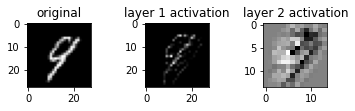

Train loss for epoch 0 : 3.3225232579596633
Test loss for epoch 0 : 3.3226840111544886
Accuracy for epoch 0 : 9.0%


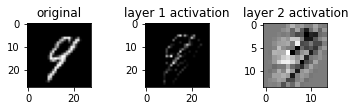

Train loss for epoch 1 : 3.322332990975794
Test loss for epoch 1 : 3.3224980913152873
Accuracy for epoch 1 : 9.0%


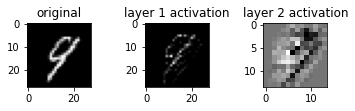

Train loss for epoch 2 : 3.322175502521482
Test loss for epoch 2 : 3.322323756227107
Accuracy for epoch 2 : 10.0%


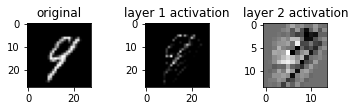

Train loss for epoch 3 : 3.322022255312527
Test loss for epoch 3 : 3.322193254516542
Accuracy for epoch 3 : 10.0%


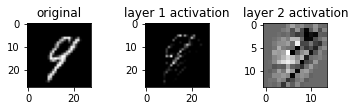

Train loss for epoch 4 : 3.3218955627041264
Test loss for epoch 4 : 3.3220670095958877
Accuracy for epoch 4 : 10.0%


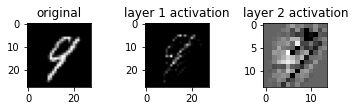

Train loss for epoch 5 : 3.321741583427975
Test loss for epoch 5 : 3.3219337914084734
Accuracy for epoch 5 : 10.0%


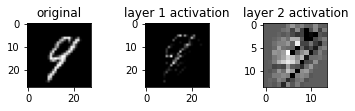

Train loss for epoch 6 : 3.3215746724932296
Test loss for epoch 6 : 3.3217900355020147
Accuracy for epoch 6 : 10.0%


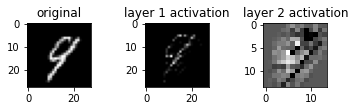

Train loss for epoch 7 : 3.321427093493255
Test loss for epoch 7 : 3.32166221749433
Accuracy for epoch 7 : 10.0%


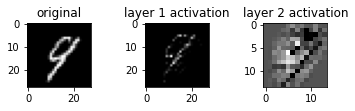

Train loss for epoch 8 : 3.321294202573614
Test loss for epoch 8 : 3.321551173429116
Accuracy for epoch 8 : 10.0%


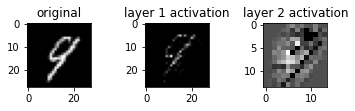

Train loss for epoch 9 : 3.321192095773523
Test loss for epoch 9 : 3.321465608980768
Accuracy for epoch 9 : 10.0%


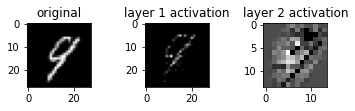

Train loss for epoch 10 : 3.3211306984705975
Test loss for epoch 10 : 3.3213997775877426
Accuracy for epoch 10 : 10.0%


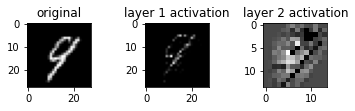

Train loss for epoch 11 : 3.3210667517211205
Test loss for epoch 11 : 3.3213556841934384
Accuracy for epoch 11 : 10.0%


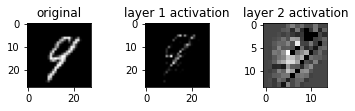

Train loss for epoch 12 : 3.32102025908304
Test loss for epoch 12 : 3.3213109496488897
Accuracy for epoch 12 : 10.0%


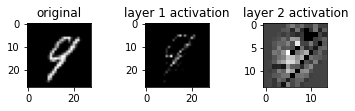

Train loss for epoch 13 : 3.320971816392598
Test loss for epoch 13 : 3.32126144915858
Accuracy for epoch 13 : 10.0%


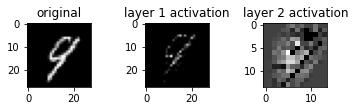

Train loss for epoch 14 : 3.320931997569282
Test loss for epoch 14 : 3.3212152187007824
Accuracy for epoch 14 : 10.0%


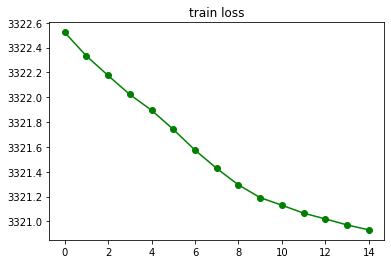

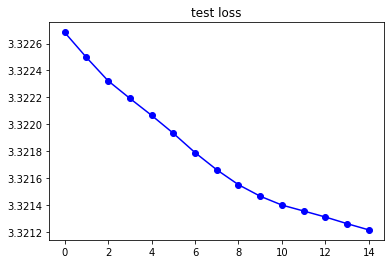

In [23]:
#batch_size = 40, SGD method is used
avg_accuracy1, parameters1, flattened_outputs_list1, original_Y_list1 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "SGD", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate, alpha, rho)

In [20]:
def hw4q6TSNE(flattened_outputs_list, original_Y_list, num_epochs):
    #print(np.squeeze(flattened_outputs_list[i], axis = -1).dtype)
    flattened_outputs_list = np.array(flattened_outputs_list, dtype="float32")
    for i in range(len(flattened_outputs_list)):
        tsne =  TSNE(n_components=2, init='random')
        Y_output = tsne.fit_transform(np.squeeze(flattened_outputs_list[i], axis = -1))
        colors = ['black', 'blue', 'green', 'red', 'yellow', 'purple', 'brown', 'magenta', 'cyan', 'orange']
        for j in range(Y_output.shape[0]):
            plt.scatter(Y_output[j, 0], Y_output[j, 1], c = colors[original_Y_list[i][j]])
            plt.annotate(original_Y_list[i][j], (Y_output[j, 0], Y_output[j, 1]))
        #plt.scatter(x_axis, y_axis)
        plt.title("tSNE plot for epoch {}".format(i*num_epochs))
        plt.legend()
        plt.show()

No handles with labels found to put in legend.


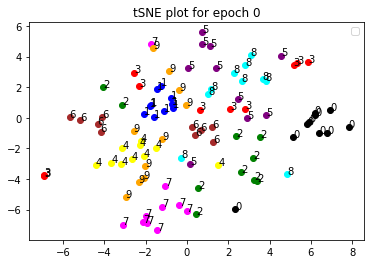

No handles with labels found to put in legend.


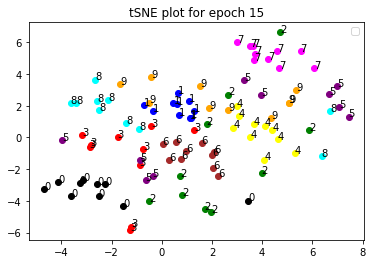

In [34]:
#tsne for SGD with batch size as 40
hw4q6TSNE(flattened_outputs_list1, original_Y_list1, num_epochs1)

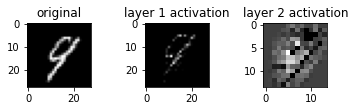

Train loss for epoch 0 : 3.3208806053877016
Test loss for epoch 0 : 3.3211988173528435
Accuracy for epoch 0 : 10.0%


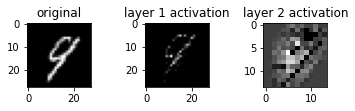

Train loss for epoch 1 : 3.3208602406984857
Test loss for epoch 1 : 3.321184474510213
Accuracy for epoch 1 : 10.0%


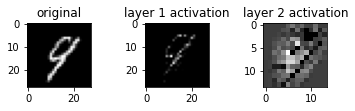

Train loss for epoch 2 : 3.3208438831440326
Test loss for epoch 2 : 3.3211707354131605
Accuracy for epoch 2 : 10.0%


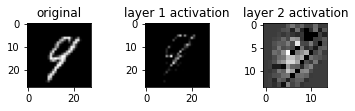

Train loss for epoch 3 : 3.3208252481135765
Test loss for epoch 3 : 3.321156666696675
Accuracy for epoch 3 : 10.0%


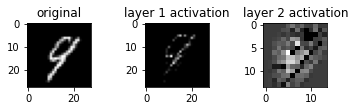

Train loss for epoch 4 : 3.320803319843596
Test loss for epoch 4 : 3.321141854445806
Accuracy for epoch 4 : 10.0%


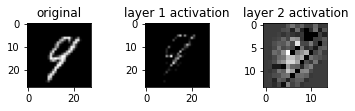

Train loss for epoch 5 : 3.3207999750298636
Test loss for epoch 5 : 3.3211267581051636
Accuracy for epoch 5 : 10.0%


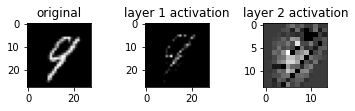

Train loss for epoch 6 : 3.3207848647957414
Test loss for epoch 6 : 3.3211135726206362
Accuracy for epoch 6 : 10.0%


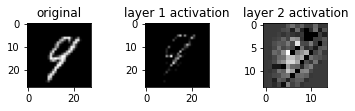

Train loss for epoch 7 : 3.320757830491675
Test loss for epoch 7 : 3.3211037967122734
Accuracy for epoch 7 : 10.0%


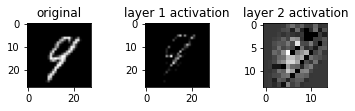

Train loss for epoch 8 : 3.320742208081378
Test loss for epoch 8 : 3.3210936880865707
Accuracy for epoch 8 : 10.0%


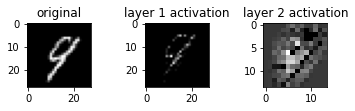

Train loss for epoch 9 : 3.3207209049815756
Test loss for epoch 9 : 3.3210840217905466
Accuracy for epoch 9 : 10.0%


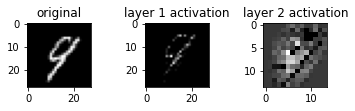

Train loss for epoch 10 : 3.320709501323708
Test loss for epoch 10 : 3.321075404210577
Accuracy for epoch 10 : 10.0%


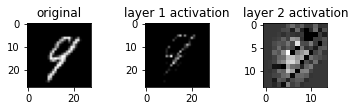

Train loss for epoch 11 : 3.3206913316864344
Test loss for epoch 11 : 3.3210664529041107
Accuracy for epoch 11 : 10.0%


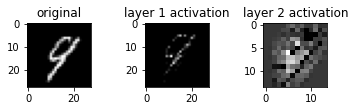

Train loss for epoch 12 : 3.320678278866595
Test loss for epoch 12 : 3.321054620323736
Accuracy for epoch 12 : 10.0%


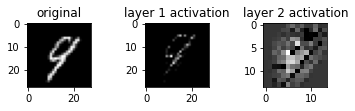

Train loss for epoch 13 : 3.3206567488874943
Test loss for epoch 13 : 3.321040793759585
Accuracy for epoch 13 : 10.0%


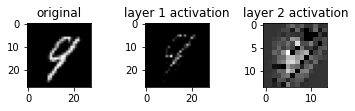

Train loss for epoch 14 : 3.3206492508334153
Test loss for epoch 14 : 3.321026017874672
Accuracy for epoch 14 : 10.0%


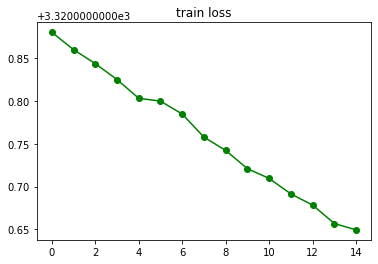

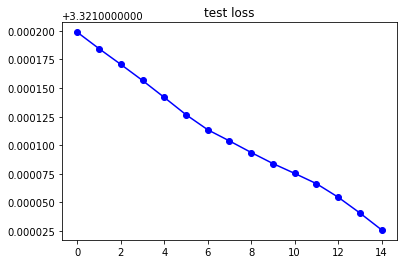

In [36]:
batch_size2 = 100.0
#batch_size = 100, SGD method is used
avg_accuracy2, parameters2, flattened_outputs_list2, original_Y_list2 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "SGD", flattening_matrix_flag, num_epochs1, batch_size2, learning_rate, alpha, rho)

#### below are the outputs with momentum using learning rate of 0.0001 (Below is the reason for using such low learning rate)
#### while using learning_rate = 0.001, the weights for kernel and MLP were vanishing (sometimes exploding) causing the final 10 dim vector output to contain Nan, which resulted in errors also to be Nan and activation maps to be blank while screen
#### There was other option as well for having a correct numerical error and accuracy by using normal distributed random weights and bias generation but I was not sure enough to use it
#### There is another possible way by reducing the number of epochs which we are learning for ignoring outputs that are vanishing to Nan
#### Same handling is being done in outputs with RMSProp also

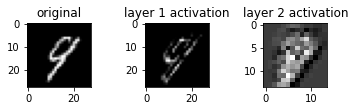

Train loss for epoch 0 : 3.3218068109150924
Test loss for epoch 0 : 3.3213196775356497
Accuracy for epoch 0 : 11.0%


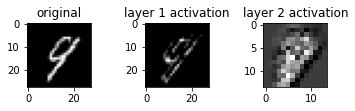

Train loss for epoch 1 : 3.321740590811889
Test loss for epoch 1 : 3.3212646547609794
Accuracy for epoch 1 : 11.0%


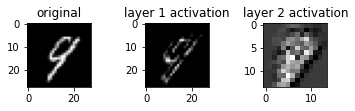

Train loss for epoch 2 : 3.3216825407569988
Test loss for epoch 2 : 3.321210730206191
Accuracy for epoch 2 : 11.0%


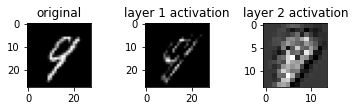

Train loss for epoch 3 : 3.3216223182332567
Test loss for epoch 3 : 3.321167736408857
Accuracy for epoch 3 : 11.0%


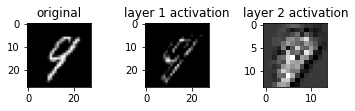

Train loss for epoch 4 : 3.3215586896981577
Test loss for epoch 4 : 3.321130691174426
Accuracy for epoch 4 : 11.0%


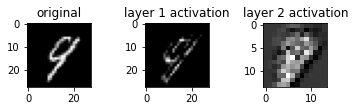

Train loss for epoch 5 : 3.3215058826671418
Test loss for epoch 5 : 3.321098471112322
Accuracy for epoch 5 : 11.0%


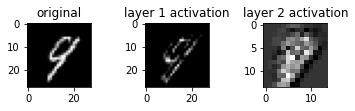

Train loss for epoch 6 : 3.321453089362866
Test loss for epoch 6 : 3.3210678118412194
Accuracy for epoch 6 : 11.0%


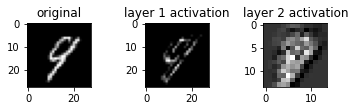

Train loss for epoch 7 : 3.3213963422140766
Test loss for epoch 7 : 3.321040560094993
Accuracy for epoch 7 : 11.0%


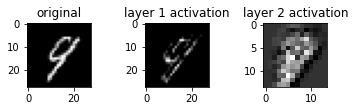

Train loss for epoch 8 : 3.3213533218496862
Test loss for epoch 8 : 3.32101904204073
Accuracy for epoch 8 : 11.0%


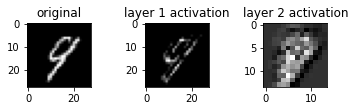

Train loss for epoch 9 : 3.321293762318528
Test loss for epoch 9 : 3.3209937922275214
Accuracy for epoch 9 : 11.0%


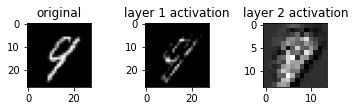

Train loss for epoch 10 : 3.321245696501267
Test loss for epoch 10 : 3.3209703098660466
Accuracy for epoch 10 : 11.0%


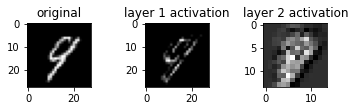

Train loss for epoch 11 : 3.321198799132698
Test loss for epoch 11 : 3.3209495126417736
Accuracy for epoch 11 : 11.0%


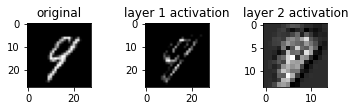

Train loss for epoch 12 : 3.32116099507705
Test loss for epoch 12 : 3.320927898018746
Accuracy for epoch 12 : 11.0%


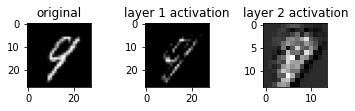

Train loss for epoch 13 : 3.3211243710097405
Test loss for epoch 13 : 3.3209118442196286
Accuracy for epoch 13 : 11.0%


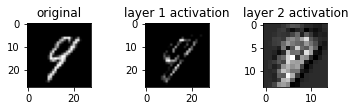

Train loss for epoch 14 : 3.321072085379892
Test loss for epoch 14 : 3.3208985612094493
Accuracy for epoch 14 : 11.0%


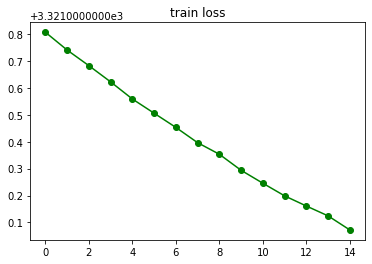

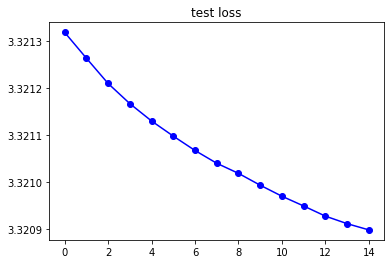

In [18]:
#batch_size = 40, momentum method is used

learning_rate2 = 0.0001
avg_accuracy3, parameters3, flattened_outputs_list3, original_Y_list3 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "momentum", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate2, alpha, rho)

No handles with labels found to put in legend.


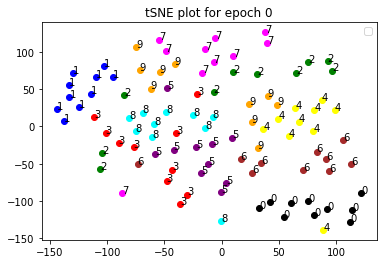

No handles with labels found to put in legend.


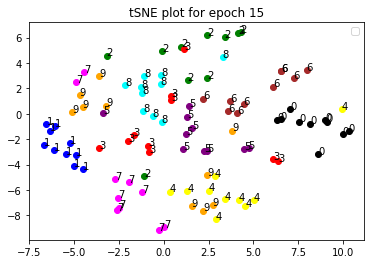

In [21]:
#tsne for momentum with batch size as 40
hw4q6TSNE(flattened_outputs_list3, original_Y_list3, num_epochs1)

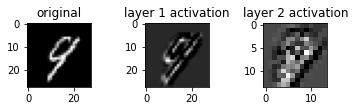

Train loss for epoch 0 : 3.321157947034408
Test loss for epoch 0 : 3.3215119742464636
Accuracy for epoch 0 : 10.0%


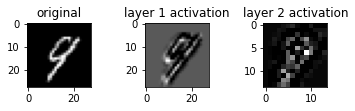

Train loss for epoch 1 : 3.3212563807745883
Test loss for epoch 1 : 3.321314723200503
Accuracy for epoch 1 : 12.0%


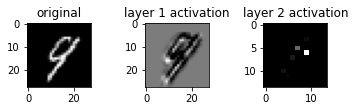

Train loss for epoch 2 : 3.3214704548556133
Test loss for epoch 2 : 3.321716114148338
Accuracy for epoch 2 : 9.0%


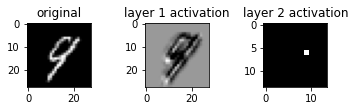

Train loss for epoch 3 : 3.321786492264012
Test loss for epoch 3 : 3.3217909052219063
Accuracy for epoch 3 : 11.0%


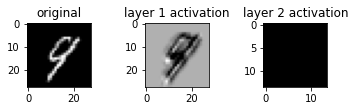

Train loss for epoch 4 : 3.321699732004232
Test loss for epoch 4 : 3.321882954015381
Accuracy for epoch 4 : 13.0%


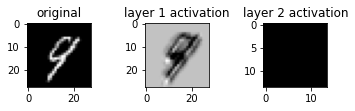

Train loss for epoch 5 : 3.321744863479121
Test loss for epoch 5 : 3.321961756636733
Accuracy for epoch 5 : 6.0%


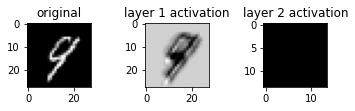

Train loss for epoch 6 : 3.3218756730753634
Test loss for epoch 6 : 3.3219878035599493
Accuracy for epoch 6 : 9.0%


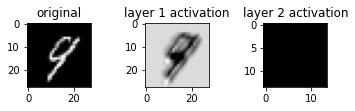

Train loss for epoch 7 : 3.3219917730338464
Test loss for epoch 7 : 3.322020187647106
Accuracy for epoch 7 : 10.0%


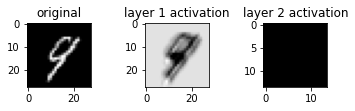

Train loss for epoch 8 : 3.322076707030138
Test loss for epoch 8 : 3.3221145808658576
Accuracy for epoch 8 : 11.0%


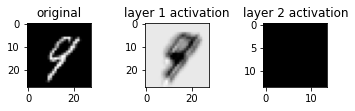

Train loss for epoch 9 : 3.322042309318674
Test loss for epoch 9 : 3.32222561265526
Accuracy for epoch 9 : 10.0%


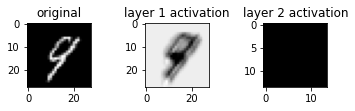

Train loss for epoch 10 : 3.3221759937366007
Test loss for epoch 10 : 3.322398099202122
Accuracy for epoch 10 : 10.0%


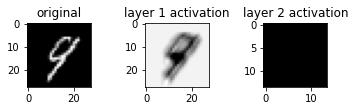

Train loss for epoch 11 : 3.3224954762952965
Test loss for epoch 11 : 3.322643899064787
Accuracy for epoch 11 : 10.0%


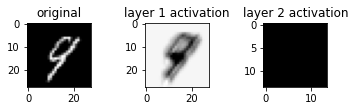

Train loss for epoch 12 : 3.3226891897685715
Test loss for epoch 12 : 3.322931386299872
Accuracy for epoch 12 : 10.0%


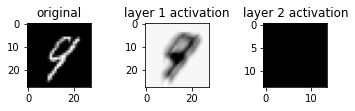

Train loss for epoch 13 : 3.3229738124294053
Test loss for epoch 13 : 3.323314932773869
Accuracy for epoch 13 : 10.0%


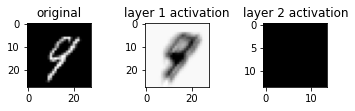

Train loss for epoch 14 : 3.3237216708583586
Test loss for epoch 14 : 3.323878602596509
Accuracy for epoch 14 : 10.0%


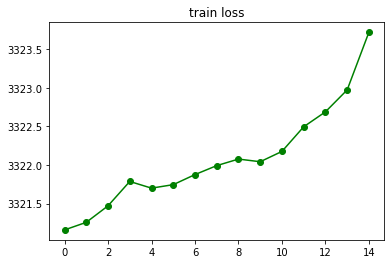

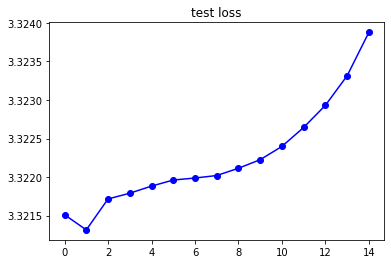

In [22]:
#batch_size = 40, RMSProp method is used
learning_rate3 = 0.0001
avg_accuracy4, parameters4, flattened_outputs_list4, original_Y_list4 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "RMSProp", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate3, alpha, rho)

No handles with labels found to put in legend.


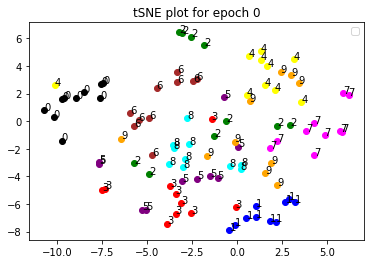

No handles with labels found to put in legend.


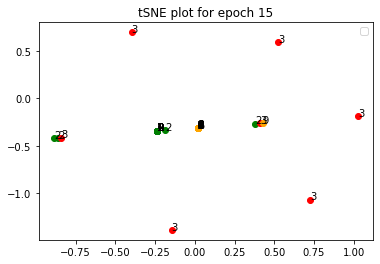

In [23]:
hw4q6TSNE(flattened_outputs_list4, original_Y_list4, num_epochs1)

## Homework 5
### q1, q2, q3, q4
Parameter for class parameter initialization

In [11]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5, 5], [5, 5]])
layer_padding = np.array([[4, 4], [4, 4]])
stride_array = np.array([[1, 1], [1, 1]])
pool_layer_size_array = np.array([[2, 2], [2, 2]])
pool_stride_array = np.array([[2, 2], [2, 2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = False
image_size = tuple(XY_train[0][0].shape)

num_epochs = 15
batch_size = 40.0
learning_rate = 0.001
momentum = 0.9
rho = 0.9

y_mapping = np.identity(output_layer_size)

loaders = {
    'train' : DataLoader(XY_train, 
                                          batch_size=40, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(XY_test, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=1)
}
#print(len(loaders['train']))

In [12]:
class hw5q1CNN(nn.Module):
    def __init__(self, image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0):
        super(hw5q1CNN, self).__init__()
        width = image_size[1]
        height = image_size[2]
        for i in range(num_kernels_array.shape[0]):
            if i == 0:
                exec("self.{} = {}".format("conv" + str(i+1), "nn.Conv2d(image_size[0], num_kernels_array[i], tuple(kernels_size_array[i]), stride = tuple(stride_array[i]), padding = 'same', bias = True, padding_mode = 'reflect')"))
            else:
                exec("self.{} = {}".format("conv" + str(i+1), "nn.Conv2d(num_kernels_array[i - 1], num_kernels_array[i], tuple(kernels_size_array[i]), stride = tuple(stride_array[i]), padding = 'same', bias = True, padding_mode = 'reflect')"))
            
            if nl_func == "ReLU":
                exec("self.{} = {}".format("activation" + str(i+1), "nn.ReLU()"))
                
            if pool_func == "maximum":
                exec("self.{} = {}".format("pool" + str(i+1), "nn.MaxPool2d(tuple(pool_layer_size_array[i]), stride=tuple(pool_stride_array[i]))"))
            
            width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
            height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
            
        if not flattening_matrix_flag:
            flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]
            
        for i in range(num_hidden_layer + 1):
            if i == num_hidden_layer:
                exec("self.{} = {}".format("fc" + str(i+1), "nn.Linear(hidden_layer_sizes[i - 1], output_layer_size, bias=True)"))
            elif i == 0:
                exec("self.{} = {}".format("fc" + str(i+1), "nn.Linear(flattening_vector_size, hidden_layer_sizes[i], bias=True)"))
            else:
                exec("self.{} = {}".format("fc" + str(i+1), "nn.Linear(hidden_layer_sizes[i - 1], hidden_layer_sizes[i], bias=True)"))
            
            if batch_norm_flag:
                if i != num_hidden_layer:
                    exec("self.{} = {}".format("batch_norm" + str(i + 1), "nn.BatchNorm1d(hidden_layer_sizes[i])"))
            
            if nl_func == "ReLU":
                if i == num_hidden_layer:
                    if softmax_flag:
                        exec("self.{} = {}".format("fc_activation" + str(i+1), "nn.Softmax(dim=1)"))
                    else:
                        exec("self.{} = {}".format("fc_activation" + str(i+1), "nn.ReLU()"))
                else:
                    exec("self.{} = {}".format("fc_activation" + str(i+1), "nn.ReLU()"))
            if dropout_flag:
                if i != num_hidden_layer:
                    #print("dropout layer initialization")
                    exec("self.{} = {}".format("dropout" + str(i+1), "nn.Dropout(p=dropout_rate)"))
    
    def forward(self, x, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag):
        activation_maps = list()
        for i in range(num_kernels_array.shape[0]):
            func = "self." + "conv" + str(i + 1)
            #print(func)
            x = eval(func + "(x)")
            #print(x.shape)
            func = "self." + "activation" + str(i + 1)
            #print(func)
            x = eval(func + "(x)")
            #print(x.shape)
            activation_maps.append(x)
            func = "self." + "pool" + str(i + 1)
            #print(func)
            x = eval(func + "(x)")
            #print(x.shape)
        if not flattening_matrix_flag:
            x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        #print(x.shape)
        output = x
        for i in range(num_hidden_layer + 1):
            func = "self." + "fc" + str(i + 1)
            #print(func)
            output = eval(func + "(output)")
            if batch_norm_flag:
                if i != num_hidden_layer:
                    #print("batch norm layer")
                    func = "self." + "batch_norm" + str(i + 1)
                    output = eval(func + "(output)")
            func = "self." + "fc_activation" + str(i + 1)
            #print(func)
            output = eval(func + "(output)")
            if dropout_flag:
                if i != num_hidden_layer:
                    #print("dropout layer")
                    func = "self." + "dropout" + str(i + 1)
                    output = eval(func + "(output)")
        return output, x, activation_maps

In [1]:
def hw5q1evaluate(loaders, cnn, y_mapping, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag):
    # Test the model
    cnn.eval()
    original_labels = list()
    with torch.no_grad():
        counter = 0
        total_loss = 0.0
        for (images, labels) in loaders['test']:
            output, flattened_output, activation_maps = cnn(images, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag)
            #pred_y = torch.max(test_output, 1)[1].data.squeeze()
            encoded_labels = list()
            counter = labels.shape[0]
            for t in range(counter):
                encoded_labels.append(y_mapping[labels[t]])
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            
            loss = loss_func(output, encoded_labels)
            accuracy = (np.argmax(output, 1) == labels).sum().item() / float(labels.size(0))
            
            total_loss += loss.item()
            original_labels = labels
            plt.subplot(3, 3, 1)
            plt.title("original")
            plt.imshow(images[counter - 1, 0, :, :], cmap="gray")
            for j in range(len(activation_maps)):
                plt.subplot(3, 3, j + 2)
                plt.title("layer {} activation".format(j + 1))
                plt.imshow(activation_maps[j][counter - 1, 0, :, :], cmap="gray")
            plt.show()
        return total_loss/counter, accuracy, flattened_output, original_labels

def hw5q1train(loaders, loss_func, cnn, optimizer, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate):
    cnn.train()
    total_step = len(loaders['train'])
    train_loss_array = list()
    test_loss_array = list()
    flattened_outputs_list = list()
    original_labels_list = list()
    for i in range(num_epochs):
        total_loss = 0.0
        for index, (images, labels) in enumerate(loaders['train']):
            #print(labels)
            b_x = Variable(images)
            b_y = Variable(labels)
            #print(b_x.shape)
            #print(b_y.shape)
            
            output, flattened_output, activation_maps = cnn(b_x, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag)
            #print(output)
            
            encoded_labels = list()
            for t in range(labels.shape[0]):
                encoded_labels.append(y_mapping[labels[t]])
            
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            
            loss = loss_func(output, encoded_labels)
            
            optimizer.zero_grad()           
            
            loss.backward()    
            
            optimizer.step() 
            
            if (index+1) % 5 == 0:
                total_loss += loss.item()
                print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'.format(i + 1, num_epochs, index + 1, total_step, loss.item()))
        train_loss_array.append(total_loss/(total_step/5))
        test_loss, test_accuracy, flattened_output, original_labels = hw5q1evaluate(loaders, cnn, y_mapping, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag)
        print("Epoch [{}/{}] | Test loss : {} | Test Accuracy : {} %".format(i + 1, num_epochs, test_loss, test_accuracy * 100))
        test_loss_array.append(test_loss)
        if i == 0:
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        elif i == (num_epochs - 1):
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        
    #print(train_loss_array)
    plt.plot(list(range(num_epochs)), train_loss_array, '-go')
    plt.title("train loss")
    plt.show()
    plt.plot(list(range(num_epochs)), test_loss_array, '-bo')
    plt.title("test loss")
    plt.show()
    return flattened_outputs_list, original_labels_list

def hw5q4TSNE(flattened_outputs_list, original_Y_list, num_epochs):
    #print(np.squeeze(flattened_outputs_list[i], axis = -1).dtype)
    flattened_outputs_list = np.array(flattened_outputs_list)
    for i in range(len(flattened_outputs_list)):
        tsne =  TSNE(n_components=2, init='random')
        #print(flattened_outputs_list[i].shape)
        Y_output = tsne.fit_transform(np.squeeze(flattened_outputs_list[i], axis = -1))
        colors = ['black', 'blue', 'green', 'red', 'yellow', 'purple', 'brown', 'magenta', 'cyan', 'orange']
        for j in range(Y_output.shape[0]):
            plt.scatter(Y_output[j, 0], Y_output[j, 1], c = colors[original_Y_list[i][j]])
            plt.annotate(original_Y_list[i][j].item(), (Y_output[j, 0], Y_output[j, 1]))
        #plt.scatter(x_axis, y_axis)
        plt.title("tSNE plot for epoch {}".format(i*(num_epochs - 1) + 1))
        plt.legend()
        plt.show()

#### Vanilla SGD

In [2]:
dropout_flag = False
batch_norm_flag = False
cnn_sgd = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0)
loss_func = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(cnn_sgd.parameters(), lr = learning_rate, momentum = 0.0)
#print(cnn(XY_train[0][0], num_kernels_array, num_hidden_layer))

NameError: name 'hw5q1CNN' is not defined

Epoch [1/15], Step [5/25], Train Loss: 2.3031
Epoch [1/15], Step [10/25], Train Loss: 2.3037
Epoch [1/15], Step [15/25], Train Loss: 2.3030
Epoch [1/15], Step [20/25], Train Loss: 2.3013
Epoch [1/15], Step [25/25], Train Loss: 2.3017


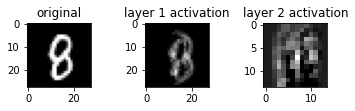

Epoch [1/15] | Test loss : 0.023024146103858948 | Test Accuracy : 10.0 %
Epoch [2/15], Step [5/25], Train Loss: 2.3018
Epoch [2/15], Step [10/25], Train Loss: 2.3040
Epoch [2/15], Step [15/25], Train Loss: 2.3029
Epoch [2/15], Step [20/25], Train Loss: 2.3006
Epoch [2/15], Step [25/25], Train Loss: 2.3016


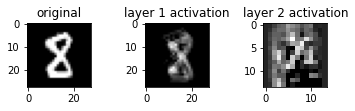

Epoch [2/15] | Test loss : 0.02302413647174835 | Test Accuracy : 10.0 %
Epoch [3/15], Step [5/25], Train Loss: 2.3025
Epoch [3/15], Step [10/25], Train Loss: 2.3028
Epoch [3/15], Step [15/25], Train Loss: 2.3026
Epoch [3/15], Step [20/25], Train Loss: 2.3022
Epoch [3/15], Step [25/25], Train Loss: 2.3031


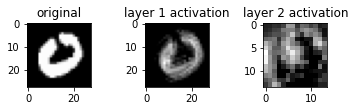

Epoch [3/15] | Test loss : 0.023024126863479613 | Test Accuracy : 10.0 %
Epoch [4/15], Step [5/25], Train Loss: 2.3037
Epoch [4/15], Step [10/25], Train Loss: 2.3027
Epoch [4/15], Step [15/25], Train Loss: 2.3043
Epoch [4/15], Step [20/25], Train Loss: 2.3025
Epoch [4/15], Step [25/25], Train Loss: 2.3027


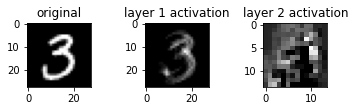

Epoch [4/15] | Test loss : 0.023024117708206178 | Test Accuracy : 10.0 %
Epoch [5/15], Step [5/25], Train Loss: 2.3042
Epoch [5/15], Step [10/25], Train Loss: 2.3007
Epoch [5/15], Step [15/25], Train Loss: 2.3018
Epoch [5/15], Step [20/25], Train Loss: 2.3019
Epoch [5/15], Step [25/25], Train Loss: 2.3028


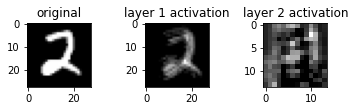

Epoch [5/15] | Test loss : 0.023024108052253724 | Test Accuracy : 10.0 %
Epoch [6/15], Step [5/25], Train Loss: 2.3043
Epoch [6/15], Step [10/25], Train Loss: 2.3041
Epoch [6/15], Step [15/25], Train Loss: 2.3019
Epoch [6/15], Step [20/25], Train Loss: 2.3023
Epoch [6/15], Step [25/25], Train Loss: 2.3029


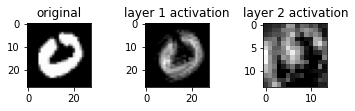

Epoch [6/15] | Test loss : 0.023024098563194272 | Test Accuracy : 10.0 %
Epoch [7/15], Step [5/25], Train Loss: 2.2996
Epoch [7/15], Step [10/25], Train Loss: 2.3015
Epoch [7/15], Step [15/25], Train Loss: 2.3032
Epoch [7/15], Step [20/25], Train Loss: 2.3026
Epoch [7/15], Step [25/25], Train Loss: 2.3038


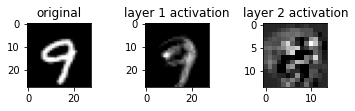

Epoch [7/15] | Test loss : 0.023024089121818542 | Test Accuracy : 10.0 %
Epoch [8/15], Step [5/25], Train Loss: 2.3033
Epoch [8/15], Step [10/25], Train Loss: 2.3054
Epoch [8/15], Step [15/25], Train Loss: 2.3020
Epoch [8/15], Step [20/25], Train Loss: 2.3019
Epoch [8/15], Step [25/25], Train Loss: 2.3028


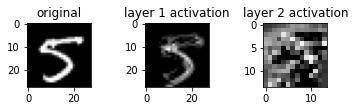

Epoch [8/15] | Test loss : 0.02302407968044281 | Test Accuracy : 10.0 %
Epoch [9/15], Step [5/25], Train Loss: 2.3024
Epoch [9/15], Step [10/25], Train Loss: 2.3017
Epoch [9/15], Step [15/25], Train Loss: 2.3026
Epoch [9/15], Step [20/25], Train Loss: 2.3031
Epoch [9/15], Step [25/25], Train Loss: 2.3009


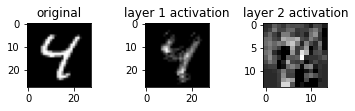

Epoch [9/15] | Test loss : 0.023024070167541506 | Test Accuracy : 10.0 %
Epoch [10/15], Step [5/25], Train Loss: 2.3024
Epoch [10/15], Step [10/25], Train Loss: 2.3022
Epoch [10/15], Step [15/25], Train Loss: 2.3042
Epoch [10/15], Step [20/25], Train Loss: 2.3013
Epoch [10/15], Step [25/25], Train Loss: 2.3021


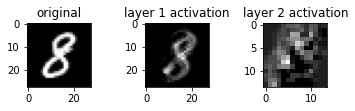

Epoch [10/15] | Test loss : 0.023024060535430907 | Test Accuracy : 10.0 %
Epoch [11/15], Step [5/25], Train Loss: 2.3028
Epoch [11/15], Step [10/25], Train Loss: 2.3029
Epoch [11/15], Step [15/25], Train Loss: 2.3032
Epoch [11/15], Step [20/25], Train Loss: 2.3023
Epoch [11/15], Step [25/25], Train Loss: 2.3036


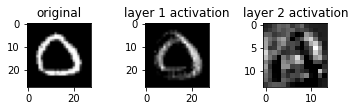

Epoch [11/15] | Test loss : 0.023024050903320315 | Test Accuracy : 10.0 %
Epoch [12/15], Step [5/25], Train Loss: 2.3031
Epoch [12/15], Step [10/25], Train Loss: 2.3040
Epoch [12/15], Step [15/25], Train Loss: 2.3048
Epoch [12/15], Step [20/25], Train Loss: 2.3028
Epoch [12/15], Step [25/25], Train Loss: 2.3022


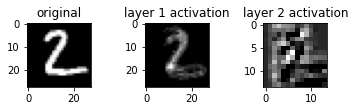

Epoch [12/15] | Test loss : 0.02302404134273529 | Test Accuracy : 10.0 %
Epoch [13/15], Step [5/25], Train Loss: 2.3044
Epoch [13/15], Step [10/25], Train Loss: 2.3037
Epoch [13/15], Step [15/25], Train Loss: 2.3010
Epoch [13/15], Step [20/25], Train Loss: 2.3043
Epoch [13/15], Step [25/25], Train Loss: 2.3020


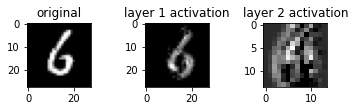

Epoch [13/15] | Test loss : 0.02302403202056885 | Test Accuracy : 10.0 %
Epoch [14/15], Step [5/25], Train Loss: 2.3033
Epoch [14/15], Step [10/25], Train Loss: 2.3000
Epoch [14/15], Step [15/25], Train Loss: 2.3035
Epoch [14/15], Step [20/25], Train Loss: 2.3040
Epoch [14/15], Step [25/25], Train Loss: 2.3026


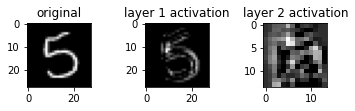

Epoch [14/15] | Test loss : 0.023024022388458253 | Test Accuracy : 10.0 %
Epoch [15/15], Step [5/25], Train Loss: 2.3001
Epoch [15/15], Step [10/25], Train Loss: 2.3056
Epoch [15/15], Step [15/25], Train Loss: 2.3032
Epoch [15/15], Step [20/25], Train Loss: 2.3023
Epoch [15/15], Step [25/25], Train Loss: 2.3022


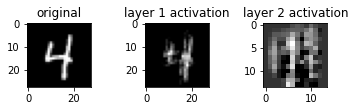

Epoch [15/15] | Test loss : 0.02302401261329651 | Test Accuracy : 10.0 %


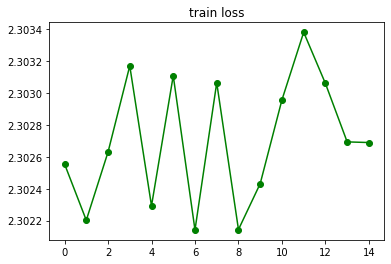

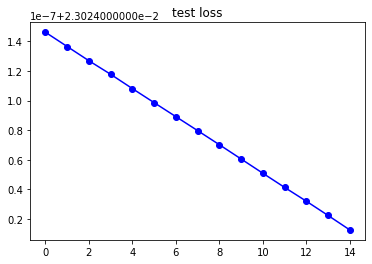

No handles with labels found to put in legend.


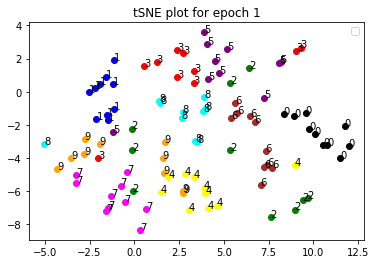

No handles with labels found to put in legend.


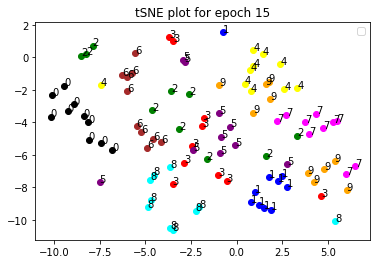

In [15]:
flattened_outputs_list1, original_labels_list1 = hw5q1train(loaders, loss_func, cnn_sgd, optimizer_sgd, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list1, original_labels_list1, num_epochs)

#### Momentum

In [11]:
dropout_flag = False
batch_norm_flag = False
cnn_momentum = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0)
loss_func = nn.CrossEntropyLoss()
optimizer_momentum = optim.SGD(cnn_momentum.parameters(), lr = learning_rate, momentum = momentum)

Epoch [1/15], Step [5/25], Train Loss: 2.3053
Epoch [1/15], Step [10/25], Train Loss: 2.3032
Epoch [1/15], Step [15/25], Train Loss: 2.3007
Epoch [1/15], Step [20/25], Train Loss: 2.3059
Epoch [1/15], Step [25/25], Train Loss: 2.3016


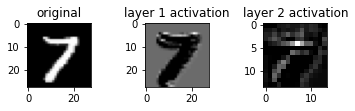

Epoch [1/15] | Test loss : 0.02302646496295929 | Test Accuracy : 10.0 %
Epoch [2/15], Step [5/25], Train Loss: 2.3038
Epoch [2/15], Step [10/25], Train Loss: 2.3002
Epoch [2/15], Step [15/25], Train Loss: 2.3030
Epoch [2/15], Step [20/25], Train Loss: 2.3057
Epoch [2/15], Step [25/25], Train Loss: 2.3034


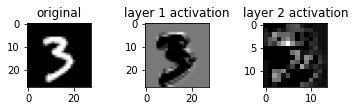

Epoch [2/15] | Test loss : 0.023026390743255614 | Test Accuracy : 10.0 %
Epoch [3/15], Step [5/25], Train Loss: 2.3045
Epoch [3/15], Step [10/25], Train Loss: 2.3048
Epoch [3/15], Step [15/25], Train Loss: 2.3007
Epoch [3/15], Step [20/25], Train Loss: 2.3025
Epoch [3/15], Step [25/25], Train Loss: 2.3020


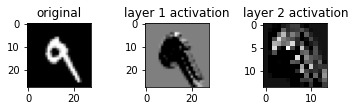

Epoch [3/15] | Test loss : 0.023026311421394347 | Test Accuracy : 10.0 %
Epoch [4/15], Step [5/25], Train Loss: 2.3015
Epoch [4/15], Step [10/25], Train Loss: 2.3002
Epoch [4/15], Step [15/25], Train Loss: 2.3028
Epoch [4/15], Step [20/25], Train Loss: 2.3056
Epoch [4/15], Step [25/25], Train Loss: 2.3069


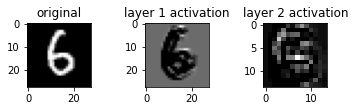

Epoch [4/15] | Test loss : 0.02302623240947723 | Test Accuracy : 10.0 %
Epoch [5/15], Step [5/25], Train Loss: 2.3028
Epoch [5/15], Step [10/25], Train Loss: 2.3047
Epoch [5/15], Step [15/25], Train Loss: 2.3028
Epoch [5/15], Step [20/25], Train Loss: 2.3029
Epoch [5/15], Step [25/25], Train Loss: 2.2992


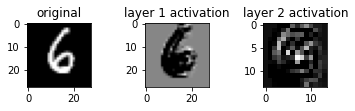

Epoch [5/15] | Test loss : 0.023026146101951597 | Test Accuracy : 10.0 %
Epoch [6/15], Step [5/25], Train Loss: 2.3039
Epoch [6/15], Step [10/25], Train Loss: 2.3016
Epoch [6/15], Step [15/25], Train Loss: 2.3019
Epoch [6/15], Step [20/25], Train Loss: 2.3043
Epoch [6/15], Step [25/25], Train Loss: 2.3003


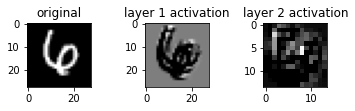

Epoch [6/15] | Test loss : 0.023026076531410217 | Test Accuracy : 10.0 %
Epoch [7/15], Step [5/25], Train Loss: 2.3045
Epoch [7/15], Step [10/25], Train Loss: 2.3040
Epoch [7/15], Step [15/25], Train Loss: 2.3033
Epoch [7/15], Step [20/25], Train Loss: 2.3024
Epoch [7/15], Step [25/25], Train Loss: 2.3020


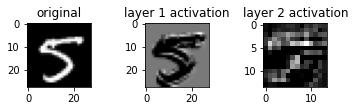

Epoch [7/15] | Test loss : 0.0230259978055954 | Test Accuracy : 10.0 %
Epoch [8/15], Step [5/25], Train Loss: 2.3014
Epoch [8/15], Step [10/25], Train Loss: 2.3015
Epoch [8/15], Step [15/25], Train Loss: 2.2996
Epoch [8/15], Step [20/25], Train Loss: 2.3032
Epoch [8/15], Step [25/25], Train Loss: 2.3032


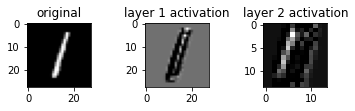

Epoch [8/15] | Test loss : 0.02302592070102692 | Test Accuracy : 10.0 %
Epoch [9/15], Step [5/25], Train Loss: 2.3037
Epoch [9/15], Step [10/25], Train Loss: 2.3017
Epoch [9/15], Step [15/25], Train Loss: 2.3035
Epoch [9/15], Step [20/25], Train Loss: 2.3040
Epoch [9/15], Step [25/25], Train Loss: 2.3015


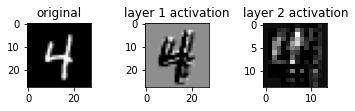

Epoch [9/15] | Test loss : 0.02302584571838379 | Test Accuracy : 10.0 %
Epoch [10/15], Step [5/25], Train Loss: 2.3019
Epoch [10/15], Step [10/25], Train Loss: 2.3028
Epoch [10/15], Step [15/25], Train Loss: 2.3045
Epoch [10/15], Step [20/25], Train Loss: 2.3010
Epoch [10/15], Step [25/25], Train Loss: 2.3036


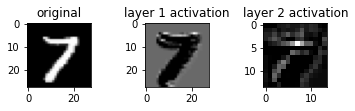

Epoch [10/15] | Test loss : 0.023025768971443178 | Test Accuracy : 10.0 %
Epoch [11/15], Step [5/25], Train Loss: 2.3025
Epoch [11/15], Step [10/25], Train Loss: 2.3048
Epoch [11/15], Step [15/25], Train Loss: 2.3057
Epoch [11/15], Step [20/25], Train Loss: 2.3039
Epoch [11/15], Step [25/25], Train Loss: 2.3045


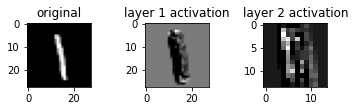

Epoch [11/15] | Test loss : 0.023025695872306823 | Test Accuracy : 10.0 %
Epoch [12/15], Step [5/25], Train Loss: 2.3006
Epoch [12/15], Step [10/25], Train Loss: 2.3027
Epoch [12/15], Step [15/25], Train Loss: 2.3035
Epoch [12/15], Step [20/25], Train Loss: 2.3015
Epoch [12/15], Step [25/25], Train Loss: 2.3038


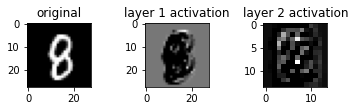

Epoch [12/15] | Test loss : 0.023025622177124023 | Test Accuracy : 10.0 %
Epoch [13/15], Step [5/25], Train Loss: 2.3035
Epoch [13/15], Step [10/25], Train Loss: 2.3013
Epoch [13/15], Step [15/25], Train Loss: 2.3048
Epoch [13/15], Step [20/25], Train Loss: 2.3024
Epoch [13/15], Step [25/25], Train Loss: 2.3034


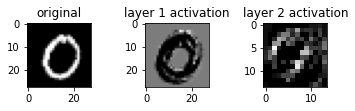

Epoch [13/15] | Test loss : 0.023025549721717834 | Test Accuracy : 10.0 %
Epoch [14/15], Step [5/25], Train Loss: 2.3038
Epoch [14/15], Step [10/25], Train Loss: 2.3026
Epoch [14/15], Step [15/25], Train Loss: 2.2996
Epoch [14/15], Step [20/25], Train Loss: 2.3055
Epoch [14/15], Step [25/25], Train Loss: 2.3014


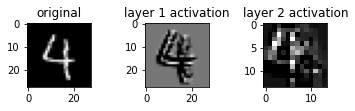

Epoch [14/15] | Test loss : 0.023025474309921266 | Test Accuracy : 10.0 %
Epoch [15/15], Step [5/25], Train Loss: 2.3018
Epoch [15/15], Step [10/25], Train Loss: 2.3003
Epoch [15/15], Step [15/25], Train Loss: 2.3051
Epoch [15/15], Step [20/25], Train Loss: 2.3040
Epoch [15/15], Step [25/25], Train Loss: 2.3052


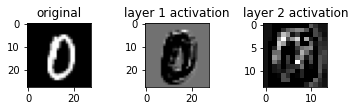

Epoch [15/15] | Test loss : 0.023025402450561522 | Test Accuracy : 10.0 %


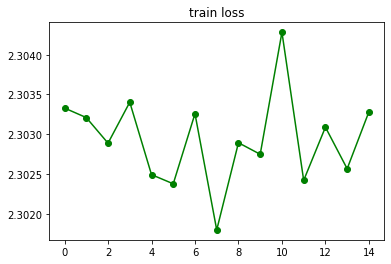

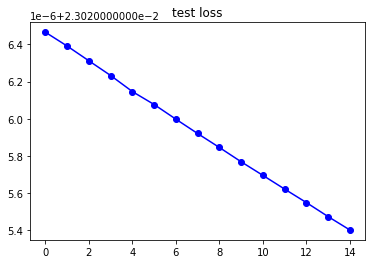

No handles with labels found to put in legend.


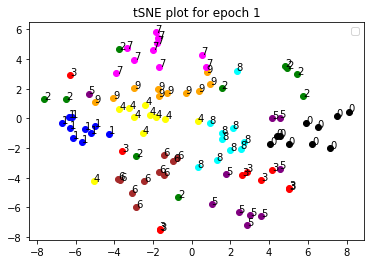

No handles with labels found to put in legend.


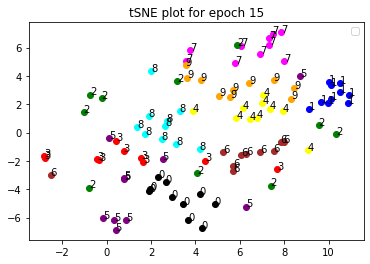

In [12]:
flattened_outputs_list2, original_labels_list2 = hw5q1train(loaders, loss_func, cnn_momentum, optimizer_momentum, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list2, original_labels_list2, num_epochs)

#### RMSProp

In [13]:
dropout_flag = False
batch_norm_flag = False
cnn_rmsprop = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0)
loss_func = nn.CrossEntropyLoss()
optimizer_rmsprop = optim.RMSprop(cnn_rmsprop.parameters(), lr = learning_rate, alpha = rho)

Epoch [1/15], Step [5/25], Train Loss: 2.3037
Epoch [1/15], Step [10/25], Train Loss: 2.2982
Epoch [1/15], Step [15/25], Train Loss: 2.2932
Epoch [1/15], Step [20/25], Train Loss: 2.2833
Epoch [1/15], Step [25/25], Train Loss: 2.2653


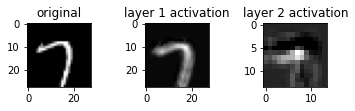

Epoch [1/15] | Test loss : 0.022587894606590272 | Test Accuracy : 37.0 %
Epoch [2/15], Step [5/25], Train Loss: 2.2152
Epoch [2/15], Step [10/25], Train Loss: 2.2175
Epoch [2/15], Step [15/25], Train Loss: 2.1757
Epoch [2/15], Step [20/25], Train Loss: 2.0573
Epoch [2/15], Step [25/25], Train Loss: 2.0497


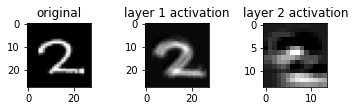

Epoch [2/15] | Test loss : 0.020244435966014863 | Test Accuracy : 62.0 %
Epoch [3/15], Step [5/25], Train Loss: 2.0102
Epoch [3/15], Step [10/25], Train Loss: 1.9155
Epoch [3/15], Step [15/25], Train Loss: 1.9262
Epoch [3/15], Step [20/25], Train Loss: 1.8665
Epoch [3/15], Step [25/25], Train Loss: 1.9447


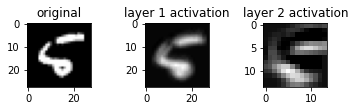

Epoch [3/15] | Test loss : 0.018581205582618714 | Test Accuracy : 67.0 %
Epoch [4/15], Step [5/25], Train Loss: 1.7900
Epoch [4/15], Step [10/25], Train Loss: 1.8435
Epoch [4/15], Step [15/25], Train Loss: 1.8092
Epoch [4/15], Step [20/25], Train Loss: 1.8310
Epoch [4/15], Step [25/25], Train Loss: 1.7864


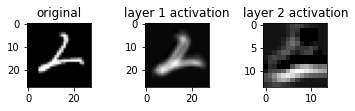

Epoch [4/15] | Test loss : 0.01778374844789505 | Test Accuracy : 79.0 %
Epoch [5/15], Step [5/25], Train Loss: 1.8422
Epoch [5/15], Step [10/25], Train Loss: 1.8195
Epoch [5/15], Step [15/25], Train Loss: 1.6967
Epoch [5/15], Step [20/25], Train Loss: 1.7816
Epoch [5/15], Step [25/25], Train Loss: 1.6974


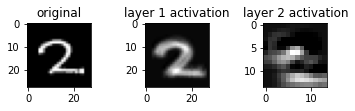

Epoch [5/15] | Test loss : 0.01730627694129944 | Test Accuracy : 78.0 %
Epoch [6/15], Step [5/25], Train Loss: 1.6260
Epoch [6/15], Step [10/25], Train Loss: 1.7597
Epoch [6/15], Step [15/25], Train Loss: 1.7087
Epoch [6/15], Step [20/25], Train Loss: 1.5780
Epoch [6/15], Step [25/25], Train Loss: 1.6743


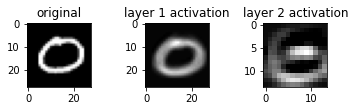

Epoch [6/15] | Test loss : 0.01669751251935959 | Test Accuracy : 84.0 %
Epoch [7/15], Step [5/25], Train Loss: 1.5999
Epoch [7/15], Step [10/25], Train Loss: 1.6585
Epoch [7/15], Step [15/25], Train Loss: 1.5904
Epoch [7/15], Step [20/25], Train Loss: 1.6812
Epoch [7/15], Step [25/25], Train Loss: 1.6382


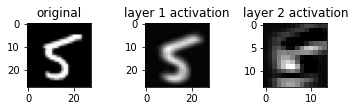

Epoch [7/15] | Test loss : 0.0164221226811409 | Test Accuracy : 86.0 %
Epoch [8/15], Step [5/25], Train Loss: 1.6576
Epoch [8/15], Step [10/25], Train Loss: 1.6191
Epoch [8/15], Step [15/25], Train Loss: 1.5837
Epoch [8/15], Step [20/25], Train Loss: 1.6611
Epoch [8/15], Step [25/25], Train Loss: 1.5777


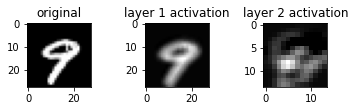

Epoch [8/15] | Test loss : 0.01626912258863449 | Test Accuracy : 86.0 %
Epoch [9/15], Step [5/25], Train Loss: 1.5468
Epoch [9/15], Step [10/25], Train Loss: 1.5733
Epoch [9/15], Step [15/25], Train Loss: 1.5553
Epoch [9/15], Step [20/25], Train Loss: 1.5522
Epoch [9/15], Step [25/25], Train Loss: 1.6047


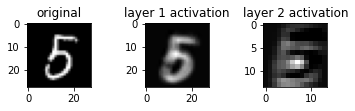

Epoch [9/15] | Test loss : 0.016222762775421142 | Test Accuracy : 88.0 %
Epoch [10/15], Step [5/25], Train Loss: 1.5037
Epoch [10/15], Step [10/25], Train Loss: 1.6306
Epoch [10/15], Step [15/25], Train Loss: 1.5469
Epoch [10/15], Step [20/25], Train Loss: 1.5730
Epoch [10/15], Step [25/25], Train Loss: 1.5463


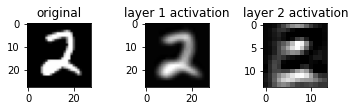

Epoch [10/15] | Test loss : 0.016077333891391755 | Test Accuracy : 87.0 %
Epoch [11/15], Step [5/25], Train Loss: 1.5764
Epoch [11/15], Step [10/25], Train Loss: 1.5317
Epoch [11/15], Step [15/25], Train Loss: 1.5346
Epoch [11/15], Step [20/25], Train Loss: 1.5958
Epoch [11/15], Step [25/25], Train Loss: 1.5333


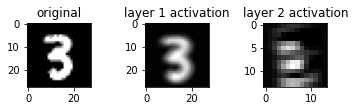

Epoch [11/15] | Test loss : 0.015959245443344115 | Test Accuracy : 90.0 %
Epoch [12/15], Step [5/25], Train Loss: 1.5864
Epoch [12/15], Step [10/25], Train Loss: 1.5183
Epoch [12/15], Step [15/25], Train Loss: 1.5222
Epoch [12/15], Step [20/25], Train Loss: 1.5146
Epoch [12/15], Step [25/25], Train Loss: 1.6119


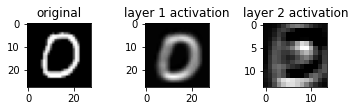

Epoch [12/15] | Test loss : 0.01594868903160095 | Test Accuracy : 88.0 %
Epoch [13/15], Step [5/25], Train Loss: 1.6062
Epoch [13/15], Step [10/25], Train Loss: 1.5388
Epoch [13/15], Step [15/25], Train Loss: 1.5237
Epoch [13/15], Step [20/25], Train Loss: 1.6300
Epoch [13/15], Step [25/25], Train Loss: 1.5759


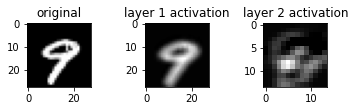

Epoch [13/15] | Test loss : 0.01619044893980026 | Test Accuracy : 85.0 %
Epoch [14/15], Step [5/25], Train Loss: 1.5173
Epoch [14/15], Step [10/25], Train Loss: 1.5603
Epoch [14/15], Step [15/25], Train Loss: 1.5612
Epoch [14/15], Step [20/25], Train Loss: 1.5820
Epoch [14/15], Step [25/25], Train Loss: 1.5728


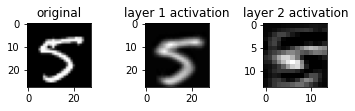

Epoch [14/15] | Test loss : 0.01578858848810196 | Test Accuracy : 89.0 %
Epoch [15/15], Step [5/25], Train Loss: 1.5440
Epoch [15/15], Step [10/25], Train Loss: 1.5337
Epoch [15/15], Step [15/25], Train Loss: 1.5290
Epoch [15/15], Step [20/25], Train Loss: 1.6054
Epoch [15/15], Step [25/25], Train Loss: 1.5573


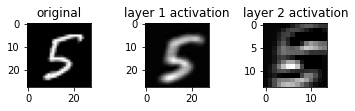

Epoch [15/15] | Test loss : 0.015530926859378815 | Test Accuracy : 92.0 %


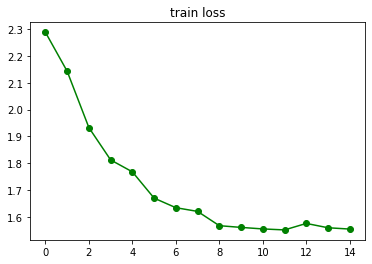

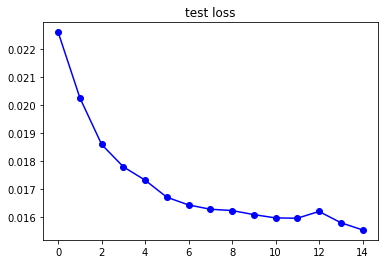

No handles with labels found to put in legend.


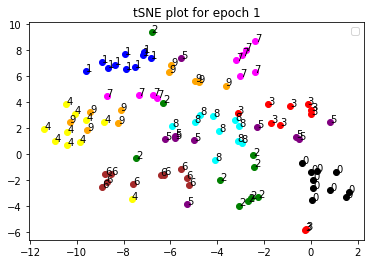

No handles with labels found to put in legend.


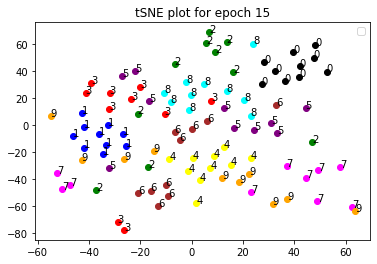

In [14]:
flattened_outputs_list3, original_labels_list3 = hw5q1train(loaders, loss_func, cnn_rmsprop, optimizer_rmsprop, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list3, original_labels_list3, num_epochs)

### q5
In homework 4, below are the outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
Vanilla SGD : 	(3.320931997569282, 3.3212152187007824, 10.0%)<br>
Momentum : 		(3.321072085379892, 3.3208985612094493, 11.0%)<br>
RMSProp : 		(3.3237216708583586, 3.323878602596509, 10.0%)

but in homework 5, below are the outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
Vanilla SGD : 	(2.3022, 0.02302401261329651, 10.0%)<br>
Momentum : 		(2.3052, 0.023025402450561522, 10.0%)<br>
RMSProp : 		(1.5573, 0.015530926859378815, 92.0%)

For Vanilla SGD and Momentum, we can see the difference in Train_loss and test loss but accuracy seems to be quite similar.<br>
For RMSProp, we can see the difference in all three measures, highest difference can be seen in the accuracy which is 82 terms more than scratch implemented RMSProp method.

#### q6


 DROPOUT : 0.2
Epoch [1/15], Step [5/25], Train Loss: 2.3029
Epoch [1/15], Step [10/25], Train Loss: 2.2972
Epoch [1/15], Step [15/25], Train Loss: 2.2954
Epoch [1/15], Step [20/25], Train Loss: 2.2849
Epoch [1/15], Step [25/25], Train Loss: 2.2864


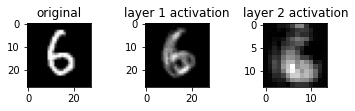

Epoch [1/15] | Test loss : 0.022698148822784425 | Test Accuracy : 30.0 %
Epoch [2/15], Step [5/25], Train Loss: 2.2523
Epoch [2/15], Step [10/25], Train Loss: 2.2295
Epoch [2/15], Step [15/25], Train Loss: 2.1975
Epoch [2/15], Step [20/25], Train Loss: 2.0649
Epoch [2/15], Step [25/25], Train Loss: 2.0946


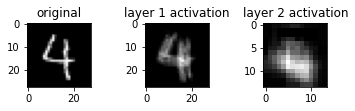

Epoch [2/15] | Test loss : 0.021036816811561585 | Test Accuracy : 42.0 %
Epoch [3/15], Step [5/25], Train Loss: 2.0355
Epoch [3/15], Step [10/25], Train Loss: 1.9386
Epoch [3/15], Step [15/25], Train Loss: 1.9652
Epoch [3/15], Step [20/25], Train Loss: 1.9256
Epoch [3/15], Step [25/25], Train Loss: 1.8505


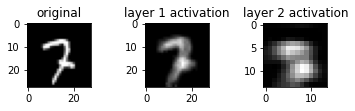

Epoch [3/15] | Test loss : 0.01926625553369522 | Test Accuracy : 59.0 %
Epoch [4/15], Step [5/25], Train Loss: 1.8291
Epoch [4/15], Step [10/25], Train Loss: 1.9855
Epoch [4/15], Step [15/25], Train Loss: 1.8314
Epoch [4/15], Step [20/25], Train Loss: 1.9070
Epoch [4/15], Step [25/25], Train Loss: 1.8563


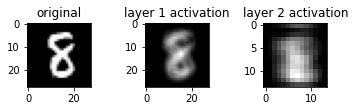

Epoch [4/15] | Test loss : 0.01861234611272812 | Test Accuracy : 63.0 %
Epoch [5/15], Step [5/25], Train Loss: 1.8360
Epoch [5/15], Step [10/25], Train Loss: 1.9115
Epoch [5/15], Step [15/25], Train Loss: 1.8271
Epoch [5/15], Step [20/25], Train Loss: 1.8366
Epoch [5/15], Step [25/25], Train Loss: 1.8734


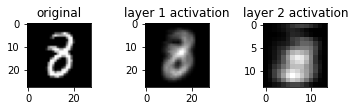

Epoch [5/15] | Test loss : 0.01824412056207657 | Test Accuracy : 66.0 %
Epoch [6/15], Step [5/25], Train Loss: 1.7104
Epoch [6/15], Step [10/25], Train Loss: 1.9057
Epoch [6/15], Step [15/25], Train Loss: 1.7268
Epoch [6/15], Step [20/25], Train Loss: 1.8684
Epoch [6/15], Step [25/25], Train Loss: 1.8959


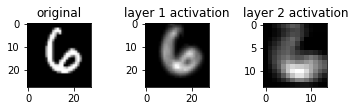

Epoch [6/15] | Test loss : 0.018176035273075104 | Test Accuracy : 69.0 %
Epoch [7/15], Step [5/25], Train Loss: 1.7258
Epoch [7/15], Step [10/25], Train Loss: 1.7691
Epoch [7/15], Step [15/25], Train Loss: 1.8826
Epoch [7/15], Step [20/25], Train Loss: 1.7267
Epoch [7/15], Step [25/25], Train Loss: 1.8757


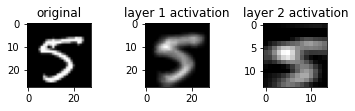

Epoch [7/15] | Test loss : 0.01789526529312134 | Test Accuracy : 72.0 %
Epoch [8/15], Step [5/25], Train Loss: 1.6827
Epoch [8/15], Step [10/25], Train Loss: 1.7870
Epoch [8/15], Step [15/25], Train Loss: 1.8380
Epoch [8/15], Step [20/25], Train Loss: 1.7217
Epoch [8/15], Step [25/25], Train Loss: 1.8459


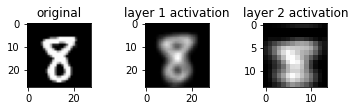

Epoch [8/15] | Test loss : 0.018044400477409364 | Test Accuracy : 66.0 %
Epoch [9/15], Step [5/25], Train Loss: 1.6915
Epoch [9/15], Step [10/25], Train Loss: 1.6981
Epoch [9/15], Step [15/25], Train Loss: 1.8300
Epoch [9/15], Step [20/25], Train Loss: 1.7626
Epoch [9/15], Step [25/25], Train Loss: 1.7938


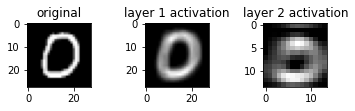

Epoch [9/15] | Test loss : 0.017838701486587526 | Test Accuracy : 68.0 %
Epoch [10/15], Step [5/25], Train Loss: 1.8010
Epoch [10/15], Step [10/25], Train Loss: 1.7183
Epoch [10/15], Step [15/25], Train Loss: 1.8638
Epoch [10/15], Step [20/25], Train Loss: 1.7506
Epoch [10/15], Step [25/25], Train Loss: 1.6841


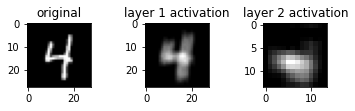

Epoch [10/15] | Test loss : 0.017583182823657992 | Test Accuracy : 72.0 %
Epoch [11/15], Step [5/25], Train Loss: 1.6757
Epoch [11/15], Step [10/25], Train Loss: 1.7691
Epoch [11/15], Step [15/25], Train Loss: 1.6507
Epoch [11/15], Step [20/25], Train Loss: 1.5930
Epoch [11/15], Step [25/25], Train Loss: 1.6616


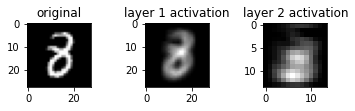

Epoch [11/15] | Test loss : 0.017007859480381013 | Test Accuracy : 78.0 %
Epoch [12/15], Step [5/25], Train Loss: 1.6528
Epoch [12/15], Step [10/25], Train Loss: 1.6610
Epoch [12/15], Step [15/25], Train Loss: 1.6411
Epoch [12/15], Step [20/25], Train Loss: 1.6054
Epoch [12/15], Step [25/25], Train Loss: 1.6993


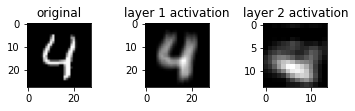

Epoch [12/15] | Test loss : 0.01698676506280899 | Test Accuracy : 76.0 %
Epoch [13/15], Step [5/25], Train Loss: 1.7194
Epoch [13/15], Step [10/25], Train Loss: 1.6671
Epoch [13/15], Step [15/25], Train Loss: 1.6600
Epoch [13/15], Step [20/25], Train Loss: 1.6068
Epoch [13/15], Step [25/25], Train Loss: 1.6590


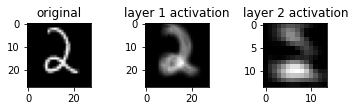

Epoch [13/15] | Test loss : 0.016942095780372618 | Test Accuracy : 77.0 %
Epoch [14/15], Step [5/25], Train Loss: 1.6656
Epoch [14/15], Step [10/25], Train Loss: 1.6923
Epoch [14/15], Step [15/25], Train Loss: 1.6814
Epoch [14/15], Step [20/25], Train Loss: 1.5677
Epoch [14/15], Step [25/25], Train Loss: 1.6992


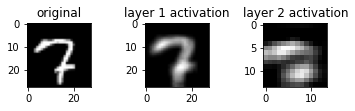

Epoch [14/15] | Test loss : 0.01704612545967102 | Test Accuracy : 77.0 %
Epoch [15/15], Step [5/25], Train Loss: 1.6344
Epoch [15/15], Step [10/25], Train Loss: 1.7149
Epoch [15/15], Step [15/25], Train Loss: 1.6749
Epoch [15/15], Step [20/25], Train Loss: 1.6738
Epoch [15/15], Step [25/25], Train Loss: 1.6097


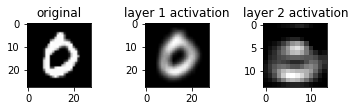

Epoch [15/15] | Test loss : 0.016813615930080416 | Test Accuracy : 79.0 %


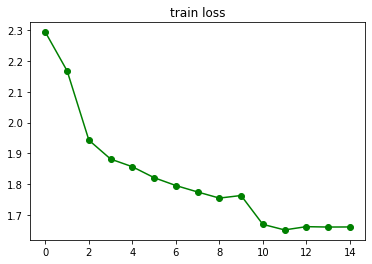

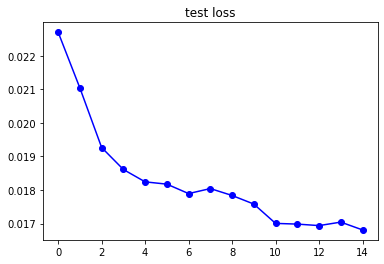

No handles with labels found to put in legend.


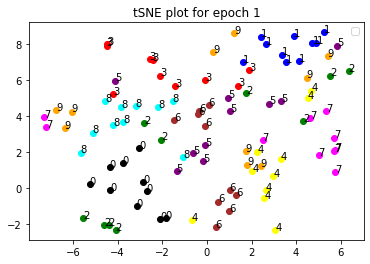

No handles with labels found to put in legend.


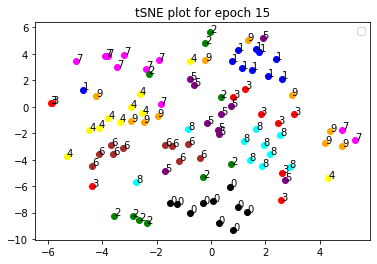


 DROPOUT : 0.5
Epoch [1/15], Step [5/25], Train Loss: 2.3029
Epoch [1/15], Step [10/25], Train Loss: 2.3000
Epoch [1/15], Step [15/25], Train Loss: 2.3037
Epoch [1/15], Step [20/25], Train Loss: 2.2969
Epoch [1/15], Step [25/25], Train Loss: 2.2990


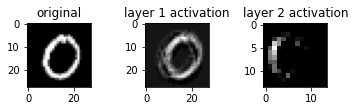

Epoch [1/15] | Test loss : 0.02292427625656128 | Test Accuracy : 10.0 %
Epoch [2/15], Step [5/25], Train Loss: 2.2624
Epoch [2/15], Step [10/25], Train Loss: 2.2783
Epoch [2/15], Step [15/25], Train Loss: 2.2518
Epoch [2/15], Step [20/25], Train Loss: 2.2295
Epoch [2/15], Step [25/25], Train Loss: 2.2013


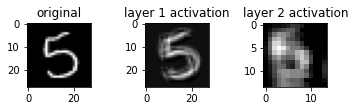

Epoch [2/15] | Test loss : 0.021866711366176603 | Test Accuracy : 39.0 %
Epoch [3/15], Step [5/25], Train Loss: 2.1396
Epoch [3/15], Step [10/25], Train Loss: 2.0823
Epoch [3/15], Step [15/25], Train Loss: 2.0740
Epoch [3/15], Step [20/25], Train Loss: 1.9723
Epoch [3/15], Step [25/25], Train Loss: 1.9872


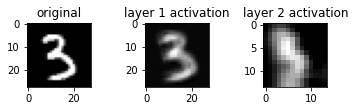

Epoch [3/15] | Test loss : 0.01991323766708374 | Test Accuracy : 56.99999999999999 %
Epoch [4/15], Step [5/25], Train Loss: 1.9800
Epoch [4/15], Step [10/25], Train Loss: 1.8363
Epoch [4/15], Step [15/25], Train Loss: 1.8862
Epoch [4/15], Step [20/25], Train Loss: 1.7758
Epoch [4/15], Step [25/25], Train Loss: 1.8968


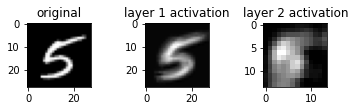

Epoch [4/15] | Test loss : 0.018831978034973145 | Test Accuracy : 64.0 %
Epoch [5/15], Step [5/25], Train Loss: 1.7877
Epoch [5/15], Step [10/25], Train Loss: 1.8470
Epoch [5/15], Step [15/25], Train Loss: 1.7706
Epoch [5/15], Step [20/25], Train Loss: 1.7009
Epoch [5/15], Step [25/25], Train Loss: 1.8297


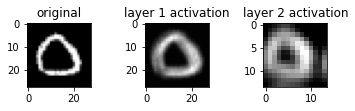

Epoch [5/15] | Test loss : 0.018088257265090942 | Test Accuracy : 72.0 %
Epoch [6/15], Step [5/25], Train Loss: 1.7595
Epoch [6/15], Step [10/25], Train Loss: 1.6888
Epoch [6/15], Step [15/25], Train Loss: 1.6628
Epoch [6/15], Step [20/25], Train Loss: 1.7089
Epoch [6/15], Step [25/25], Train Loss: 1.7196


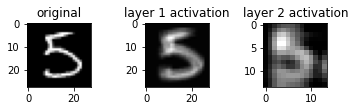

Epoch [6/15] | Test loss : 0.017732782304286956 | Test Accuracy : 72.0 %
Epoch [7/15], Step [5/25], Train Loss: 1.7091
Epoch [7/15], Step [10/25], Train Loss: 1.6237
Epoch [7/15], Step [15/25], Train Loss: 1.6195
Epoch [7/15], Step [20/25], Train Loss: 1.6556
Epoch [7/15], Step [25/25], Train Loss: 1.6142


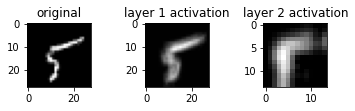

Epoch [7/15] | Test loss : 0.0171553582906723 | Test Accuracy : 82.0 %
Epoch [8/15], Step [5/25], Train Loss: 1.6950
Epoch [8/15], Step [10/25], Train Loss: 1.7816
Epoch [8/15], Step [15/25], Train Loss: 1.7106
Epoch [8/15], Step [20/25], Train Loss: 1.7056
Epoch [8/15], Step [25/25], Train Loss: 1.6438


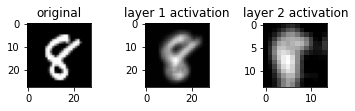

Epoch [8/15] | Test loss : 0.016999146807193756 | Test Accuracy : 79.0 %
Epoch [9/15], Step [5/25], Train Loss: 1.6467
Epoch [9/15], Step [10/25], Train Loss: 1.7307
Epoch [9/15], Step [15/25], Train Loss: 1.7527
Epoch [9/15], Step [20/25], Train Loss: 1.6820
Epoch [9/15], Step [25/25], Train Loss: 1.7506


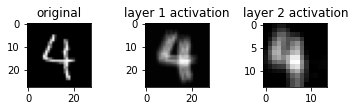

Epoch [9/15] | Test loss : 0.016818996620178224 | Test Accuracy : 81.0 %
Epoch [10/15], Step [5/25], Train Loss: 1.6566
Epoch [10/15], Step [10/25], Train Loss: 1.6226
Epoch [10/15], Step [15/25], Train Loss: 1.6185
Epoch [10/15], Step [20/25], Train Loss: 1.6579
Epoch [10/15], Step [25/25], Train Loss: 1.6653


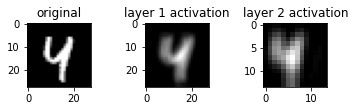

Epoch [10/15] | Test loss : 0.01675153045654297 | Test Accuracy : 80.0 %
Epoch [11/15], Step [5/25], Train Loss: 1.6152
Epoch [11/15], Step [10/25], Train Loss: 1.6352
Epoch [11/15], Step [15/25], Train Loss: 1.6565
Epoch [11/15], Step [20/25], Train Loss: 1.5463
Epoch [11/15], Step [25/25], Train Loss: 1.6583


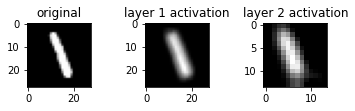

Epoch [11/15] | Test loss : 0.016632325506210327 | Test Accuracy : 84.0 %
Epoch [12/15], Step [5/25], Train Loss: 1.6422
Epoch [12/15], Step [10/25], Train Loss: 1.6070
Epoch [12/15], Step [15/25], Train Loss: 1.5801
Epoch [12/15], Step [20/25], Train Loss: 1.6565
Epoch [12/15], Step [25/25], Train Loss: 1.6878


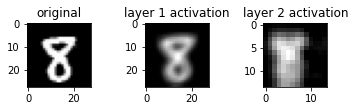

Epoch [12/15] | Test loss : 0.016508500134944915 | Test Accuracy : 83.0 %
Epoch [13/15], Step [5/25], Train Loss: 1.5594
Epoch [13/15], Step [10/25], Train Loss: 1.6562
Epoch [13/15], Step [15/25], Train Loss: 1.6398
Epoch [13/15], Step [20/25], Train Loss: 1.6569
Epoch [13/15], Step [25/25], Train Loss: 1.6874


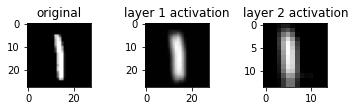

Epoch [13/15] | Test loss : 0.016520384192466736 | Test Accuracy : 82.0 %
Epoch [14/15], Step [5/25], Train Loss: 1.6067
Epoch [14/15], Step [10/25], Train Loss: 1.5572
Epoch [14/15], Step [15/25], Train Loss: 1.7153
Epoch [14/15], Step [20/25], Train Loss: 1.5464
Epoch [14/15], Step [25/25], Train Loss: 1.5620


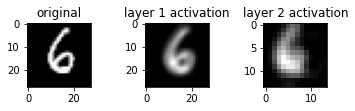

Epoch [14/15] | Test loss : 0.01642445160150528 | Test Accuracy : 83.0 %
Epoch [15/15], Step [5/25], Train Loss: 1.6062
Epoch [15/15], Step [10/25], Train Loss: 1.6942
Epoch [15/15], Step [15/25], Train Loss: 1.6089
Epoch [15/15], Step [20/25], Train Loss: 1.7409
Epoch [15/15], Step [25/25], Train Loss: 1.6375


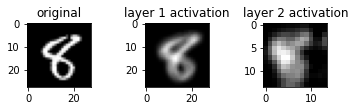

Epoch [15/15] | Test loss : 0.016699135875701904 | Test Accuracy : 82.0 %


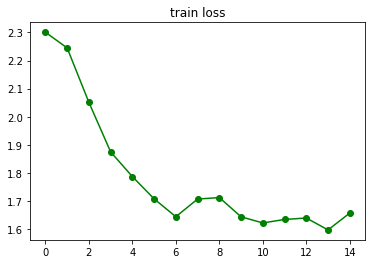

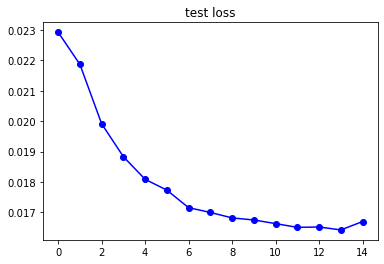

No handles with labels found to put in legend.


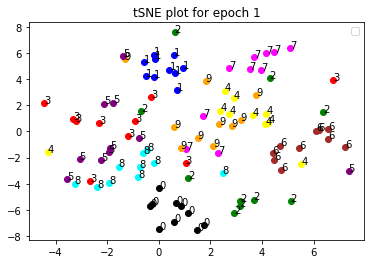

No handles with labels found to put in legend.


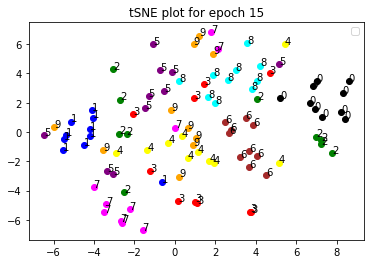


 DROPOUT : 0.8
Epoch [1/15], Step [5/25], Train Loss: 2.3026
Epoch [1/15], Step [10/25], Train Loss: 2.3006
Epoch [1/15], Step [15/25], Train Loss: 2.3017
Epoch [1/15], Step [20/25], Train Loss: 2.3012
Epoch [1/15], Step [25/25], Train Loss: 2.2999


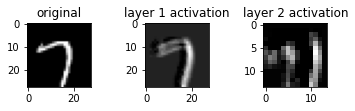

Epoch [1/15] | Test loss : 0.02291473379135132 | Test Accuracy : 34.0 %
Epoch [2/15], Step [5/25], Train Loss: 2.2910
Epoch [2/15], Step [10/25], Train Loss: 2.2679
Epoch [2/15], Step [15/25], Train Loss: 2.2536
Epoch [2/15], Step [20/25], Train Loss: 2.2143
Epoch [2/15], Step [25/25], Train Loss: 2.1729


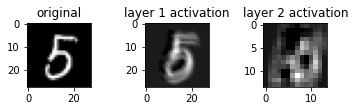

Epoch [2/15] | Test loss : 0.0220032745718956 | Test Accuracy : 26.0 %
Epoch [3/15], Step [5/25], Train Loss: 2.1626
Epoch [3/15], Step [10/25], Train Loss: 2.0707
Epoch [3/15], Step [15/25], Train Loss: 2.1135
Epoch [3/15], Step [20/25], Train Loss: 2.0527
Epoch [3/15], Step [25/25], Train Loss: 1.9056


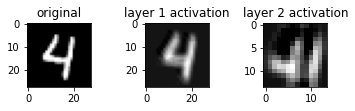

Epoch [3/15] | Test loss : 0.020049977600574493 | Test Accuracy : 60.0 %
Epoch [4/15], Step [5/25], Train Loss: 2.0087
Epoch [4/15], Step [10/25], Train Loss: 1.9940
Epoch [4/15], Step [15/25], Train Loss: 1.9013
Epoch [4/15], Step [20/25], Train Loss: 1.9347
Epoch [4/15], Step [25/25], Train Loss: 1.7890


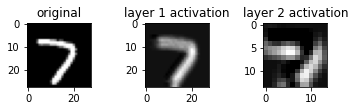

Epoch [4/15] | Test loss : 0.01862763432264328 | Test Accuracy : 67.0 %
Epoch [5/15], Step [5/25], Train Loss: 1.7848
Epoch [5/15], Step [10/25], Train Loss: 1.8077
Epoch [5/15], Step [15/25], Train Loss: 1.7389
Epoch [5/15], Step [20/25], Train Loss: 1.7693
Epoch [5/15], Step [25/25], Train Loss: 1.7971


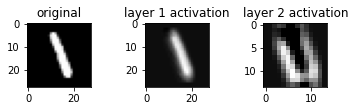

Epoch [5/15] | Test loss : 0.018067454504966735 | Test Accuracy : 69.0 %
Epoch [6/15], Step [5/25], Train Loss: 1.8755
Epoch [6/15], Step [10/25], Train Loss: 1.7315
Epoch [6/15], Step [15/25], Train Loss: 1.6813
Epoch [6/15], Step [20/25], Train Loss: 1.7144
Epoch [6/15], Step [25/25], Train Loss: 1.7168


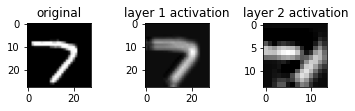

Epoch [6/15] | Test loss : 0.017613208413124085 | Test Accuracy : 74.0 %
Epoch [7/15], Step [5/25], Train Loss: 1.8073
Epoch [7/15], Step [10/25], Train Loss: 1.7023
Epoch [7/15], Step [15/25], Train Loss: 1.7685
Epoch [7/15], Step [20/25], Train Loss: 1.7456
Epoch [7/15], Step [25/25], Train Loss: 1.7048


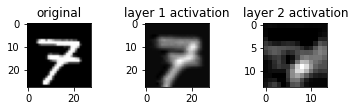

Epoch [7/15] | Test loss : 0.017403969335556033 | Test Accuracy : 75.0 %
Epoch [8/15], Step [5/25], Train Loss: 1.7201
Epoch [8/15], Step [10/25], Train Loss: 1.7327
Epoch [8/15], Step [15/25], Train Loss: 1.7503
Epoch [8/15], Step [20/25], Train Loss: 1.7045
Epoch [8/15], Step [25/25], Train Loss: 1.6655


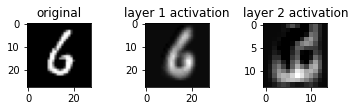

Epoch [8/15] | Test loss : 0.01701939533948898 | Test Accuracy : 78.0 %
Epoch [9/15], Step [5/25], Train Loss: 1.6915
Epoch [9/15], Step [10/25], Train Loss: 1.6073
Epoch [9/15], Step [15/25], Train Loss: 1.6461
Epoch [9/15], Step [20/25], Train Loss: 1.6593
Epoch [9/15], Step [25/25], Train Loss: 1.7678


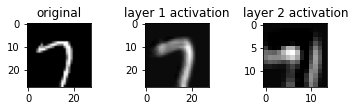

Epoch [9/15] | Test loss : 0.016767412042617797 | Test Accuracy : 82.0 %
Epoch [10/15], Step [5/25], Train Loss: 1.6604
Epoch [10/15], Step [10/25], Train Loss: 1.6247
Epoch [10/15], Step [15/25], Train Loss: 1.7479
Epoch [10/15], Step [20/25], Train Loss: 1.7038
Epoch [10/15], Step [25/25], Train Loss: 1.6009


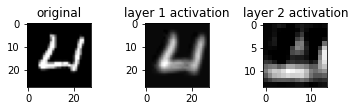

Epoch [10/15] | Test loss : 0.01660943776369095 | Test Accuracy : 82.0 %
Epoch [11/15], Step [5/25], Train Loss: 1.6869
Epoch [11/15], Step [10/25], Train Loss: 1.7084
Epoch [11/15], Step [15/25], Train Loss: 1.6605
Epoch [11/15], Step [20/25], Train Loss: 1.6813
Epoch [11/15], Step [25/25], Train Loss: 1.6116


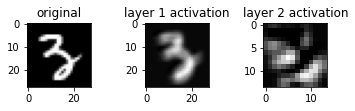

Epoch [11/15] | Test loss : 0.01632499121427536 | Test Accuracy : 86.0 %
Epoch [12/15], Step [5/25], Train Loss: 1.6093
Epoch [12/15], Step [10/25], Train Loss: 1.5571
Epoch [12/15], Step [15/25], Train Loss: 1.5897
Epoch [12/15], Step [20/25], Train Loss: 1.7270
Epoch [12/15], Step [25/25], Train Loss: 1.6116


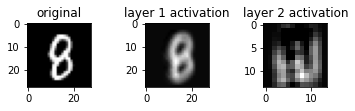

Epoch [12/15] | Test loss : 0.01621577137708664 | Test Accuracy : 87.0 %
Epoch [13/15], Step [5/25], Train Loss: 1.5866
Epoch [13/15], Step [10/25], Train Loss: 1.5583
Epoch [13/15], Step [15/25], Train Loss: 1.6681
Epoch [13/15], Step [20/25], Train Loss: 1.6252
Epoch [13/15], Step [25/25], Train Loss: 1.6073


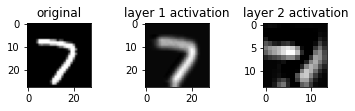

Epoch [13/15] | Test loss : 0.016168010699748995 | Test Accuracy : 87.0 %
Epoch [14/15], Step [5/25], Train Loss: 1.5790
Epoch [14/15], Step [10/25], Train Loss: 1.6803
Epoch [14/15], Step [15/25], Train Loss: 1.5685
Epoch [14/15], Step [20/25], Train Loss: 1.5823
Epoch [14/15], Step [25/25], Train Loss: 1.5428


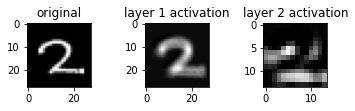

Epoch [14/15] | Test loss : 0.01633221951723099 | Test Accuracy : 82.0 %
Epoch [15/15], Step [5/25], Train Loss: 1.5556
Epoch [15/15], Step [10/25], Train Loss: 1.5227
Epoch [15/15], Step [15/25], Train Loss: 1.5368
Epoch [15/15], Step [20/25], Train Loss: 1.5494
Epoch [15/15], Step [25/25], Train Loss: 1.6516


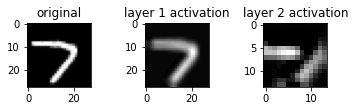

Epoch [15/15] | Test loss : 0.01631328603029251 | Test Accuracy : 83.0 %


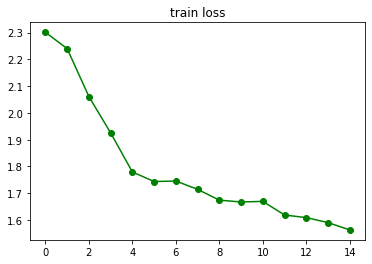

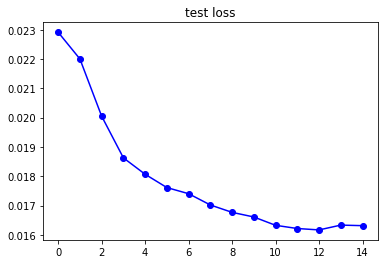

No handles with labels found to put in legend.


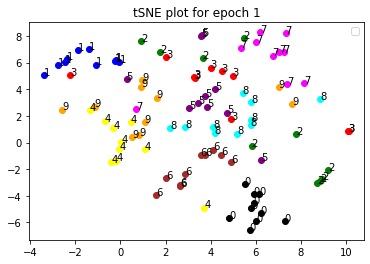

No handles with labels found to put in legend.


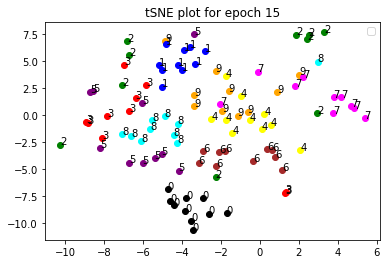

In [16]:
dropout_flag = True
batch_norm_flag = False
for dropout in [0.2, 0.5, 0.8]:
    print("\n DROPOUT : {}".format(dropout))
    temp_cnn = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = dropout)
    loss_func = nn.CrossEntropyLoss()
    temp_optimizer_rmsprop = optim.RMSprop(temp_cnn.parameters(), lr = learning_rate, alpha = rho)
    flattened_outputs_list, original_labels_list = hw5q1train(loaders, loss_func, temp_cnn, temp_optimizer_rmsprop, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
    hw5q4TSNE(flattened_outputs_list, original_labels_list, num_epochs)

(1) Without dropout using RMSProp optimizer, we had outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
RMSProp : (1.5573, 0.015530926859378815, 92.0%)<br>

(2) With difference values of dropout, below are the outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
dropout = 0.2 : (1.6097, 0.016813615930080416, 79.0 %)<br>
dropout = 0.5 : (1.6375, 0.016699135875701904, 82.0 %)<br>
dropout = 0.8 : (1.6516, 0.01631328603029251, 83.0 %)

We can see that without dropout (1), we had lower losses and more accuracy than we have with different values of dropout (2).<br>
Comparing between increasing values of dropout (0.2, 0.5, 0.8), train loss is increasing, test loss is decreasing and accuracy is also increasing.

### q7 (I am using RMSProp as the optimizer because no specific optimizer was mentioned in the question)

Epoch [1/15], Step [5/25], Train Loss: 2.2719
Epoch [1/15], Step [10/25], Train Loss: 2.2597
Epoch [1/15], Step [15/25], Train Loss: 2.2140
Epoch [1/15], Step [20/25], Train Loss: 2.1257
Epoch [1/15], Step [25/25], Train Loss: 2.1432


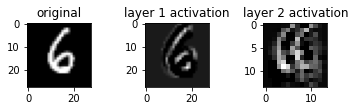

Epoch [1/15] | Test loss : 0.022868801975250243 | Test Accuracy : 39.0 %
Epoch [2/15], Step [5/25], Train Loss: 2.2766
Epoch [2/15], Step [10/25], Train Loss: 2.2736
Epoch [2/15], Step [15/25], Train Loss: 2.2096
Epoch [2/15], Step [20/25], Train Loss: 2.1945
Epoch [2/15], Step [25/25], Train Loss: 2.1417


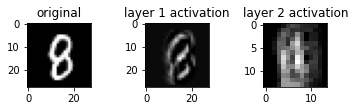

Epoch [2/15] | Test loss : 0.021480339896678923 | Test Accuracy : 39.0 %
Epoch [3/15], Step [5/25], Train Loss: 2.0087
Epoch [3/15], Step [10/25], Train Loss: 2.0248
Epoch [3/15], Step [15/25], Train Loss: 1.9364
Epoch [3/15], Step [20/25], Train Loss: 1.8711
Epoch [3/15], Step [25/25], Train Loss: 1.7808


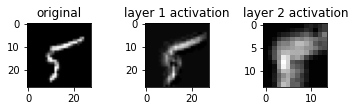

Epoch [3/15] | Test loss : 0.018420237851142884 | Test Accuracy : 74.0 %
Epoch [4/15], Step [5/25], Train Loss: 1.7553
Epoch [4/15], Step [10/25], Train Loss: 1.7933
Epoch [4/15], Step [15/25], Train Loss: 1.6579
Epoch [4/15], Step [20/25], Train Loss: 1.7431
Epoch [4/15], Step [25/25], Train Loss: 1.7586


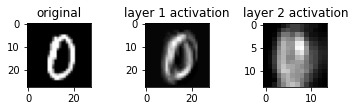

Epoch [4/15] | Test loss : 0.017234219586849214 | Test Accuracy : 79.0 %
Epoch [5/15], Step [5/25], Train Loss: 1.7301
Epoch [5/15], Step [10/25], Train Loss: 1.6625
Epoch [5/15], Step [15/25], Train Loss: 1.6667
Epoch [5/15], Step [20/25], Train Loss: 1.5603
Epoch [5/15], Step [25/25], Train Loss: 1.6825


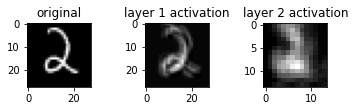

Epoch [5/15] | Test loss : 0.017240374529361724 | Test Accuracy : 76.0 %
Epoch [6/15], Step [5/25], Train Loss: 1.6865
Epoch [6/15], Step [10/25], Train Loss: 1.6191
Epoch [6/15], Step [15/25], Train Loss: 1.6520
Epoch [6/15], Step [20/25], Train Loss: 1.6317
Epoch [6/15], Step [25/25], Train Loss: 1.6390


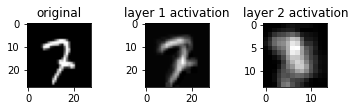

Epoch [6/15] | Test loss : 0.016569290637969972 | Test Accuracy : 81.0 %
Epoch [7/15], Step [5/25], Train Loss: 1.5809
Epoch [7/15], Step [10/25], Train Loss: 1.6417
Epoch [7/15], Step [15/25], Train Loss: 1.5891
Epoch [7/15], Step [20/25], Train Loss: 1.6639
Epoch [7/15], Step [25/25], Train Loss: 1.5564


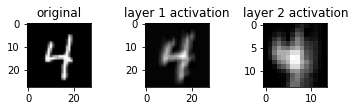

Epoch [7/15] | Test loss : 0.016528888738155365 | Test Accuracy : 81.0 %
Epoch [8/15], Step [5/25], Train Loss: 1.6487
Epoch [8/15], Step [10/25], Train Loss: 1.6544
Epoch [8/15], Step [15/25], Train Loss: 1.5536
Epoch [8/15], Step [20/25], Train Loss: 1.5616
Epoch [8/15], Step [25/25], Train Loss: 1.5716


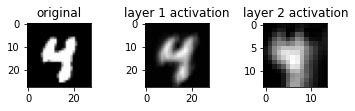

Epoch [8/15] | Test loss : 0.016110956299304962 | Test Accuracy : 86.0 %
Epoch [9/15], Step [5/25], Train Loss: 1.6989
Epoch [9/15], Step [10/25], Train Loss: 1.5374
Epoch [9/15], Step [15/25], Train Loss: 1.6215
Epoch [9/15], Step [20/25], Train Loss: 1.5674
Epoch [9/15], Step [25/25], Train Loss: 1.5810


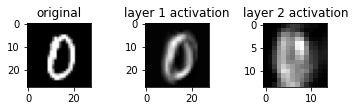

Epoch [9/15] | Test loss : 0.016553246045112612 | Test Accuracy : 83.0 %
Epoch [10/15], Step [5/25], Train Loss: 1.6280
Epoch [10/15], Step [10/25], Train Loss: 1.5917
Epoch [10/15], Step [15/25], Train Loss: 1.5938
Epoch [10/15], Step [20/25], Train Loss: 1.5896
Epoch [10/15], Step [25/25], Train Loss: 1.6047


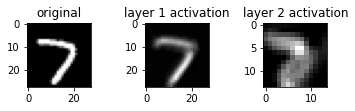

Epoch [10/15] | Test loss : 0.01605646960735321 | Test Accuracy : 85.0 %
Epoch [11/15], Step [5/25], Train Loss: 1.5900
Epoch [11/15], Step [10/25], Train Loss: 1.5177
Epoch [11/15], Step [15/25], Train Loss: 1.5492
Epoch [11/15], Step [20/25], Train Loss: 1.5489
Epoch [11/15], Step [25/25], Train Loss: 1.5732


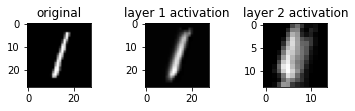

Epoch [11/15] | Test loss : 0.016174442303180693 | Test Accuracy : 84.0 %
Epoch [12/15], Step [5/25], Train Loss: 1.5392
Epoch [12/15], Step [10/25], Train Loss: 1.5038
Epoch [12/15], Step [15/25], Train Loss: 1.5730
Epoch [12/15], Step [20/25], Train Loss: 1.5168
Epoch [12/15], Step [25/25], Train Loss: 1.5263


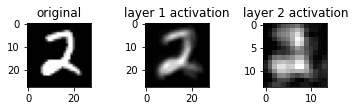

Epoch [12/15] | Test loss : 0.015874402630329132 | Test Accuracy : 88.0 %
Epoch [13/15], Step [5/25], Train Loss: 1.5144
Epoch [13/15], Step [10/25], Train Loss: 1.5929
Epoch [13/15], Step [15/25], Train Loss: 1.5298
Epoch [13/15], Step [20/25], Train Loss: 1.5629
Epoch [13/15], Step [25/25], Train Loss: 1.4933


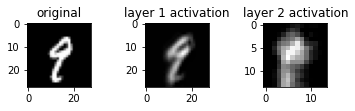

Epoch [13/15] | Test loss : 0.015900123882293702 | Test Accuracy : 88.0 %
Epoch [14/15], Step [5/25], Train Loss: 1.5577
Epoch [14/15], Step [10/25], Train Loss: 1.5775
Epoch [14/15], Step [15/25], Train Loss: 1.5808
Epoch [14/15], Step [20/25], Train Loss: 1.4915
Epoch [14/15], Step [25/25], Train Loss: 1.5511


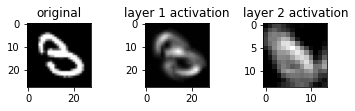

Epoch [14/15] | Test loss : 0.016034561002254488 | Test Accuracy : 85.0 %
Epoch [15/15], Step [5/25], Train Loss: 1.5456
Epoch [15/15], Step [10/25], Train Loss: 1.4670
Epoch [15/15], Step [15/25], Train Loss: 1.5065
Epoch [15/15], Step [20/25], Train Loss: 1.5660
Epoch [15/15], Step [25/25], Train Loss: 1.4942


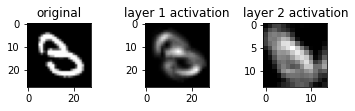

Epoch [15/15] | Test loss : 0.016010110449790955 | Test Accuracy : 87.0 %


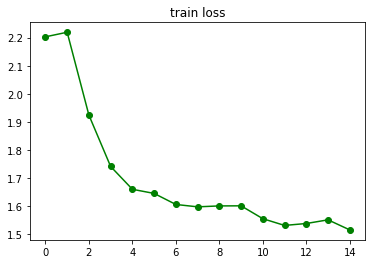

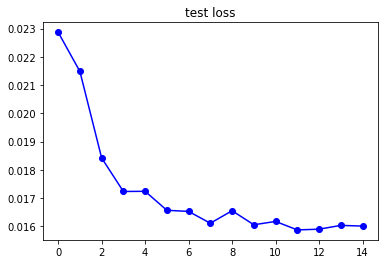

No handles with labels found to put in legend.


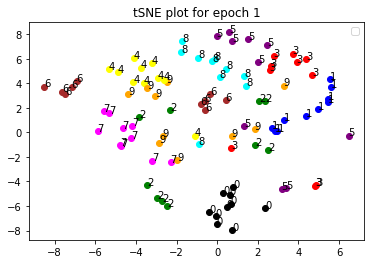

No handles with labels found to put in legend.


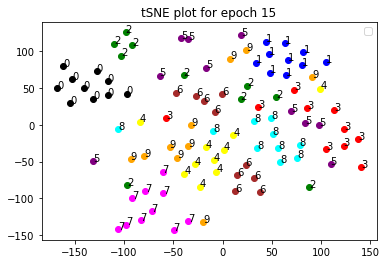

In [17]:
dropout_flag = True
batch_norm_flag = True
temp_cnn_batch_norm = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.2)
loss_func = nn.CrossEntropyLoss()
optimizer_rmsprop_batch_norm = optim.RMSprop(temp_cnn_batch_norm.parameters(), lr = learning_rate, alpha = rho)
flattened_outputs_list, original_labels_list = hw5q1train(loaders, loss_func, temp_cnn_batch_norm, optimizer_rmsprop_batch_norm, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list, original_labels_list, num_epochs)

(1) Vanilla Implementation without dropout using RMSProp optimizer, we had outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
: (1.5573, 0.015530926859378815, 92.0%)<br>

(2) Implementation with dropout = 0.2 using RMSProp optimizer, we had outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
: (1.6097, 0.016813615930080416, 79.0 %)<br>

(3) Implementation with dropout = 0.2 and batchnormalization of MLP hidden layer using RMSProp optimizer, we have outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
: (1.4942, 0.016010110449790955, 87.0 %)<br>

Comparing Vanilla Implementation (1) and batch norm dropout implementation (3), we see there is decrease in train loss but accuracy has reduced and test loss has increased.<br>
Comparing Dropout implementation (2) and batch norm dropout implementation (3), we see there is decrease in train loss, test loss and also accuracy has increased which means dropout with batch normalization gives better accuracy and performance than dropout implemented alone.<br>